In [3]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import os


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import acquire
import prepare

In [4]:
def prep_telco():
    telco_churn_db = acquire.get_telco_data()
    telco_churn_db = telco_churn_db.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    dummy_telco_churn_db = pd.get_dummies(telco_churn_db[['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'contract_type', 'internet_service_type', 'payment_type']], dummy_na=False, drop_first=True)
    telco_churn_db = pd.concat([telco_churn_db, dummy_telco_churn_db], axis=1)
    return telco_churn_db

In [5]:
t = acquire.get_telco_data()
t.shape

(7043, 25)

In [6]:
def prep_telco_alternative():
    telco_churn_db = acquire.get_telco_data()
    telco_churn_db = telco_churn_db.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    dummy_telco_churn_db = pd.get_dummies(telco_churn_db[['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn', 'internet_service_type', 'payment_type']], dummy_na=False, drop_first=True)
    #Since month-to-month seems VERY correlated to churn rate I am not dropping first when doing contract type specifically for knn nearest neighbors where I have to cut down the dimensions and choose the best correlated issues.  
    #I expect the decision trees to give me more intuition on the most highly correlated dimensions to choose
    dummy_telco_churn_db_first = pd.get_dummies(telco_churn_db[['contract_type']], dummy_na=False, drop_first=False) 
    telco_churn_db = pd.concat([telco_churn_db, dummy_telco_churn_db, dummy_telco_churn_db_first], axis=1)
    return telco_churn_db

In [7]:
def split_data(df, stratify_col):
    train_validate, test = train_test_split(df, test_size = .2, random_state=823, stratify=df[stratify_col])
    train, validate = train_test_split(train_validate, test_size=.25, random_state=823, stratify=train_validate[stratify_col])
    return train, validate, test

In [10]:
telco = prep_telco_alternative()
telco.dtypes

Unnamed: 0                                 int64
customer_id                               object
gender                                    object
senior_citizen                             int64
partner                                   object
dependents                                object
tenure                                     int64
phone_service                             object
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
paperless_billing                         object
monthly_charges                          float64
total_charges                             object
churn                                     object
contract_type                             object
internet_service_typ

In [11]:
telco = telco.drop(columns=telco.select_dtypes(exclude='number').columns)

In [12]:
telco.dtypes

Unnamed: 0                                 int64
senior_citizen                             int64
tenure                                     int64
monthly_charges                          float64
gender_Male                                uint8
partner_Yes                                uint8
dependents_Yes                             uint8
phone_service_Yes                          uint8
multiple_lines_No phone service            uint8
multiple_lines_Yes                         uint8
online_security_No internet service        uint8
online_security_Yes                        uint8
online_backup_No internet service          uint8
online_backup_Yes                          uint8
device_protection_No internet service      uint8
device_protection_Yes                      uint8
tech_support_No internet service           uint8
tech_support_Yes                           uint8
streaming_tv_No internet service           uint8
streaming_tv_Yes                           uint8
streaming_movies_No 

Generalized Null hypothesis (For each Column): "Column" is independant of the Churn rate
Generalized Alt hypothesis (For each Column): "Column" and Churn rate are dependant
\alpha < 0.01.  Higher alpha is justified because n is large and there are so many columns to choose from

In [13]:
telco.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [14]:
baseline = 1869/(1869+5174)
baseline

0.2653698707936959

In [15]:
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

churn_Yes   0  1
Unnamed: 0      
0           1  0
1           1  0
2           0  1
3           0  1
4           0  1
...        .. ..
7038        1  0
7039        0  1
7040        1  0
7041        1  0
7042        1  0

[7043 rows x 2 columns]
(chi squared = 7043.0, p = 0.49439767459438705
___________________________________________________________
churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes    0    1
tenure             
0           11    0
1          233  380
2          115  123
3          106   94
4           93   83
5           69   64
6           70   40
7           80   51
8           81   42
9           73   46
10          71   45
11          68   31
12          79   38
13          71   38
14          52   24
15          62   37
16          52   28
17          61   26
18          73   2

churn_Yes                  0     1
contract_type_Two year            
0                       3527  1821
1                       1647    48
(chi squared = 641.8281150143744, p = 1.3376802517066984e-141
___________________________________________________________


"Unnamed: 0", "gender_male", "phone_service_Yes", "multiple_lines_No phone service" all do not meet the p-value we set and thus we do not have sufficient evidence to reject the null hypothesis.  Therefore I am dropping them all from the analysis.  "Unnamed: 0" is just an id number so it makes sense that they are independant events...kinda goes without saying but a good sanity check.

In [16]:
telco = telco.drop(columns=['Unnamed: 0', 'gender_Male', 'phone_service_Yes', 'multiple_lines_No phone service'])
telco

senior_citizen  tenure  monthly_charges  partner_Yes  dependents_Yes  \
0                  0       9            65.60            1               1   
1                  0       9            59.90            0               0   
2                  0       4            73.90            0               0   
3                  1      13            98.00            1               0   
4                  1       3            83.90            1               0   
...              ...     ...              ...          ...             ...   
7038               0      13            55.15            0               0   
7039               0      22            85.10            1               0   
7040               0       2            50.30            0               0   
7041               0      67            67.85            1               1   
7042               0      63            59.00            1               1   

      multiple_lines_Yes  online_security_No internet service  \
0                      0                                    0   
1                      1                                    0   
2                      0                                    0   
3                      0                                    0   
4                      0                                    0   
...                  ...                                  ...   
7038                   0                                    0   
7039                   1                                    0   
7040                   0                                    0   
7041                   0                                    0   
7042                   0                                    0   

      online_security_Yes  online_backup_No internet service  \
0                       0                                  0   
1                       0                                  0   
2                       0                                  0   
3                       0                                  0   
4                       0                                  0   
...                   ...                                ...   
7038                    1                                  0   
7039                    0                                  0   
7040                    0                                  0   
7041                    1                                  0   
7042                    1                                  0   

      online_backup_Yes  ...  paperless_billing_Yes  churn_Yes  \
0                     1  ...                      1          0   
1                     0  ...                      0          0   
2                     0  ...                      1          1   
3                     1  ...                      1          1   
4                     0  ...                      1          1   
...                 ...  ...                    ...        ...   
7038                  0  ...                      0          0   
7039                  0  ...                      1          1   
7040                  1  ...                      1          0   
7041                  0  ...                      0          0   
7042                  1  ...                      0          0   

      internet_service_type_Fiber optic  internet_service_type_None  \
0                                     0                           0   
1                                     0                           0   
2                                     1                           0   
3                                     1                           0   
4                                     1                           0   
...                                 ...                         ...   
7038                                  0                           0   
7039                                  1                           0   
7040                                  0                           0   
7041            

### 

<Axes: xlabel='monthly_charges', ylabel='tenure'>

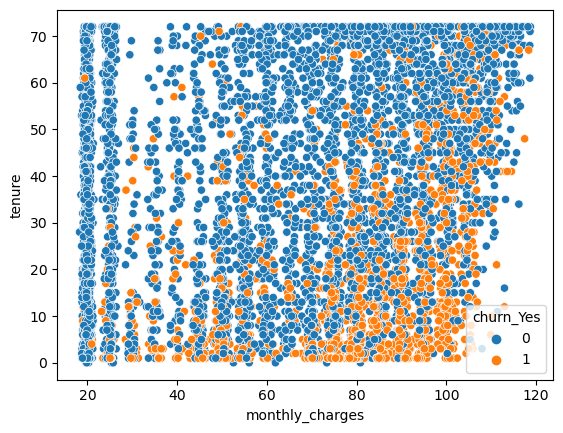

In [146]:
sns.scatterplot(telco, x='monthly_charges', y='tenure', hue='churn_Yes')

In [17]:
continuous = pd.crosstab(telco.monthly_charges, telco.tenure)
continuous

tenure           0   1   2   3   4   5   6   7   8   9   ...  63  64  65  66  \
monthly_charges                                          ...                   
18.25             0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
18.40             0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
18.55             0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
18.70             0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
18.75             0   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   
...              ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
118.20            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
118.35            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
118.60            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
118.65            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
118.75            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   

tenure           67  68  69  70  71  72  
monthly_charges                          
18.25             0   0   0   0   0   0  
18.40             0   0   0   0   0   0  
18.55             0   0   0   0   0   0  
18.70             0   0   0   0   0   0  
18.75             0   0   0   0   0   0  
...              ..  ..  ..  ..  ..  ..  
118.20            0   0   0   0   0   1  
118.35            1   0   0   0   0   0  
118.60            0   1   0   0   0   0  
118.65            0   0   0   0   1   0  
118.75            0   0   0   0   0   1  

[1585 rows x 73 columns]

In [18]:
telco['charge_tenure_ratio'] = telco.tenure/telco.monthly_charges
telco

senior_citizen  tenure  monthly_charges  partner_Yes  dependents_Yes  \
0                  0       9            65.60            1               1   
1                  0       9            59.90            0               0   
2                  0       4            73.90            0               0   
3                  1      13            98.00            1               0   
4                  1       3            83.90            1               0   
...              ...     ...              ...          ...             ...   
7038               0      13            55.15            0               0   
7039               0      22            85.10            1               0   
7040               0       2            50.30            0               0   
7041               0      67            67.85            1               1   
7042               0      63            59.00            1               1   

      multiple_lines_Yes  online_security_No internet service  \
0                      0                                    0   
1                      1                                    0   
2                      0                                    0   
3                      0                                    0   
4                      0                                    0   
...                  ...                                  ...   
7038                   0                                    0   
7039                   1                                    0   
7040                   0                                    0   
7041                   0                                    0   
7042                   0                                    0   

      online_security_Yes  online_backup_No internet service  \
0                       0                                  0   
1                       0                                  0   
2                       0                                  0   
3                       0                                  0   
4                       0                                  0   
...                   ...                                ...   
7038                    1                                  0   
7039                    0                                  0   
7040                    0                                  0   
7041                    1                                  0   
7042                    1                                  0   

      online_backup_Yes  ...  churn_Yes  internet_service_type_Fiber optic  \
0                     1  ...          0                                  0   
1                     0  ...          0                                  0   
2                     0  ...          1                                  1   
3                     1  ...          1                                  1   
4                     0  ...          1                                  1   
...                 ...  ...        ...                                ...   
7038                  0  ...          0                                  0   
7039                  0  ...          1                                  1   
7040                  1  ...          0                                  0   
7041                  0  ...          0                                  0   
7042                  1  ...          0                                  0   

      internet_service_type_None  payment_type_Credit card (automatic)  \
0                              0                                     0   
1                              0                                     0   
2                              0                                     0   
3                              0                                     0   
4                              0                                     0   
...                          ...                                   ...   
7038                           0                                

<Axes: xlabel='churn_Yes', ylabel='charge_tenure_ratio'>

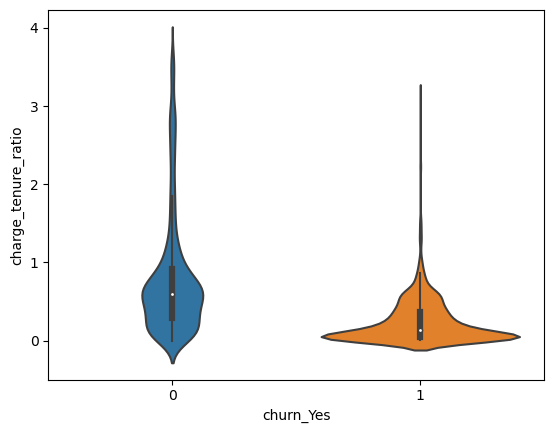

In [20]:
sns.violinplot(data=telco, x='churn_Yes', y='charge_tenure_ratio')

/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 68.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='churn_Yes', ylabel='charge_tenure_ratio'>

/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 76.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 79.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


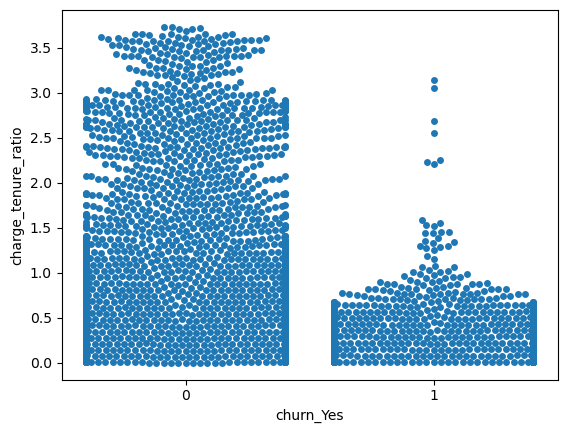

In [101]:
sns.swarmplot(data=telco, x='churn_Yes', y='charge_tenure_ratio')

<Axes: xlabel='churn_Yes', ylabel='charge_tenure_ratio'>

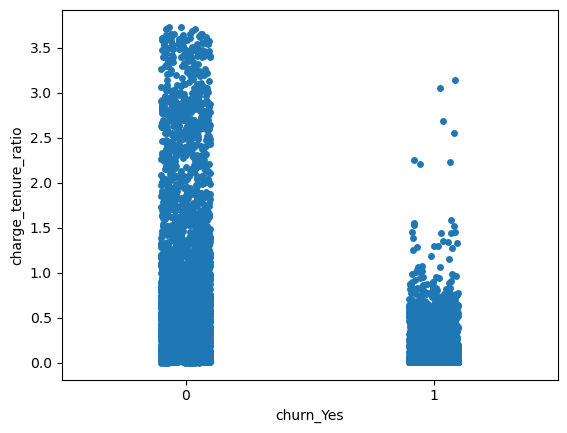

In [102]:
sns.stripplot(data=telco, x='churn_Yes', y='charge_tenure_ratio')

<Axes: xlabel='tenure', ylabel='monthly_charges'>

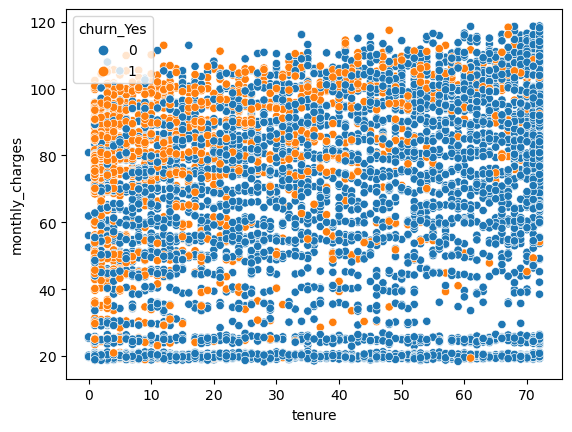

In [24]:
sns.scatterplot(data=telco, x='tenure', y='monthly_charges', hue='churn_Yes')

In [19]:
chi2, p, degf, expected = stats.chi2_contingency(continuous)
chi2, p, degf, expected

(117599.75576015131,
 9.036150061814391e-14,
 114048,
 array([[0.00156183, 0.08703677, 0.03379242, ..., 0.01689621, 0.02413744,
         0.05139855],
        [0.00156183, 0.08703677, 0.03379242, ..., 0.01689621, 0.02413744,
         0.05139855],
        [0.00156183, 0.08703677, 0.03379242, ..., 0.01689621, 0.02413744,
         0.05139855],
        ...,
        [0.00312367, 0.17407355, 0.06758484, ..., 0.03379242, 0.04827488,
         0.1027971 ],
        [0.00156183, 0.08703677, 0.03379242, ..., 0.01689621, 0.02413744,
         0.05139855],
        [0.00156183, 0.08703677, 0.03379242, ..., 0.01689621, 0.02413744,
         0.05139855]]))

In [20]:
stats.pearsonr(telco.monthly_charges, telco.tenure)

PearsonRResult(statistic=0.24789985628615005, pvalue=4.0940449915016345e-99)

### I am normaizing the tenure and monthly charges so as to optimize the knn predictions.  These should not have an adverse effect of trees random forests or the logistic regression models as the calc ulations are scaled accordingly.  In addition the logistic regression should be simplified as well.

In [21]:
telco['tenure_normalized'] = (telco.tenure - telco.tenure.min()) / (telco.tenure.max() - telco.tenure.min())

In [22]:
telco['monthly_charges_normalized'] = (telco.monthly_charges - telco.monthly_charges.min()) / (telco.monthly_charges.max() - telco.monthly_charges.min())

In [23]:
telco = telco.drop(columns=['tenure', 'monthly_charges'])

In [24]:
telco = telco.drop(columns=['online_backup_No internet service', 'device_protection_No internet service', 'tech_support_No internet service', 'streaming_tv_No internet service', 'streaming_movies_No internet service', 'online_security_No internet service'])

In [25]:
for col in telco.columns:
    col = pd.crosstab(telco[col], telco.churn_Yes)
    print(col)
    col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
    print(f'(chi squared = {col_chi2}, p = {col_p}')
    print('___________________________________________________________')

churn_Yes          0     1
senior_citizen            
0               4508  1393
1                666   476
(chi squared = 159.42630036838742, p = 1.510066805092378e-36
___________________________________________________________
churn_Yes       0     1
partner_Yes            
0            2441  1200
1            2733   669
(chi squared = 158.7333820309922, p = 2.1399113440759935e-36
___________________________________________________________
churn_Yes          0     1
dependents_Yes            
0               3390  1543
1               1784   326
(chi squared = 189.12924940423474, p = 4.9249216612154196e-43
___________________________________________________________
churn_Yes              0     1
multiple_lines_Yes            
0                   3053  1019
1                   2121   850
(chi squared = 11.143251001456251, p = 0.0008433795342472428
___________________________________________________________
churn_Yes               0     1
online_security_Yes            
0              

In [26]:
telco.shape

(7043, 23)

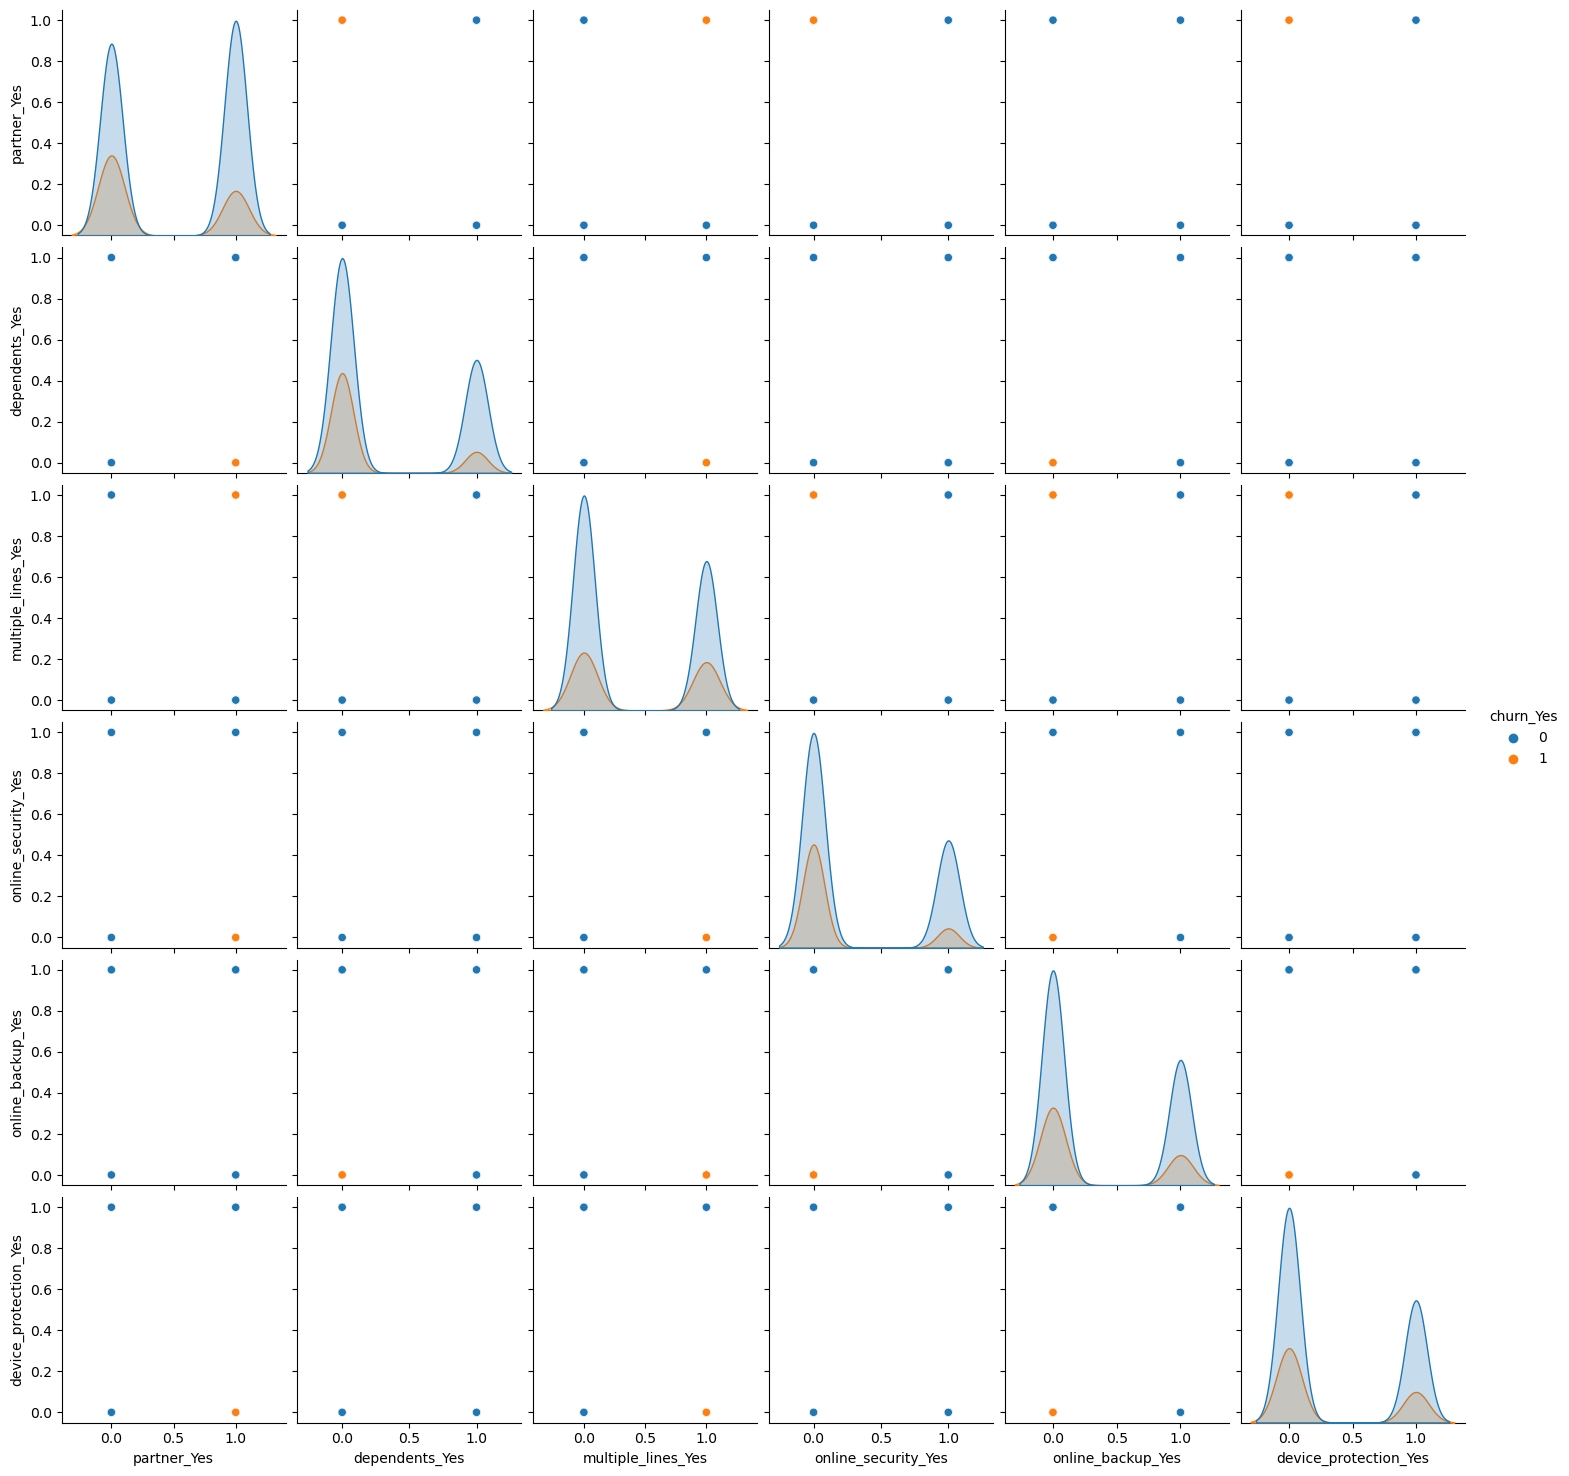

In [33]:
sns.pairplot(telco, x_vars = telco.columns[1:7], y_vars=telco.columns[1:7], hue='churn_Yes')

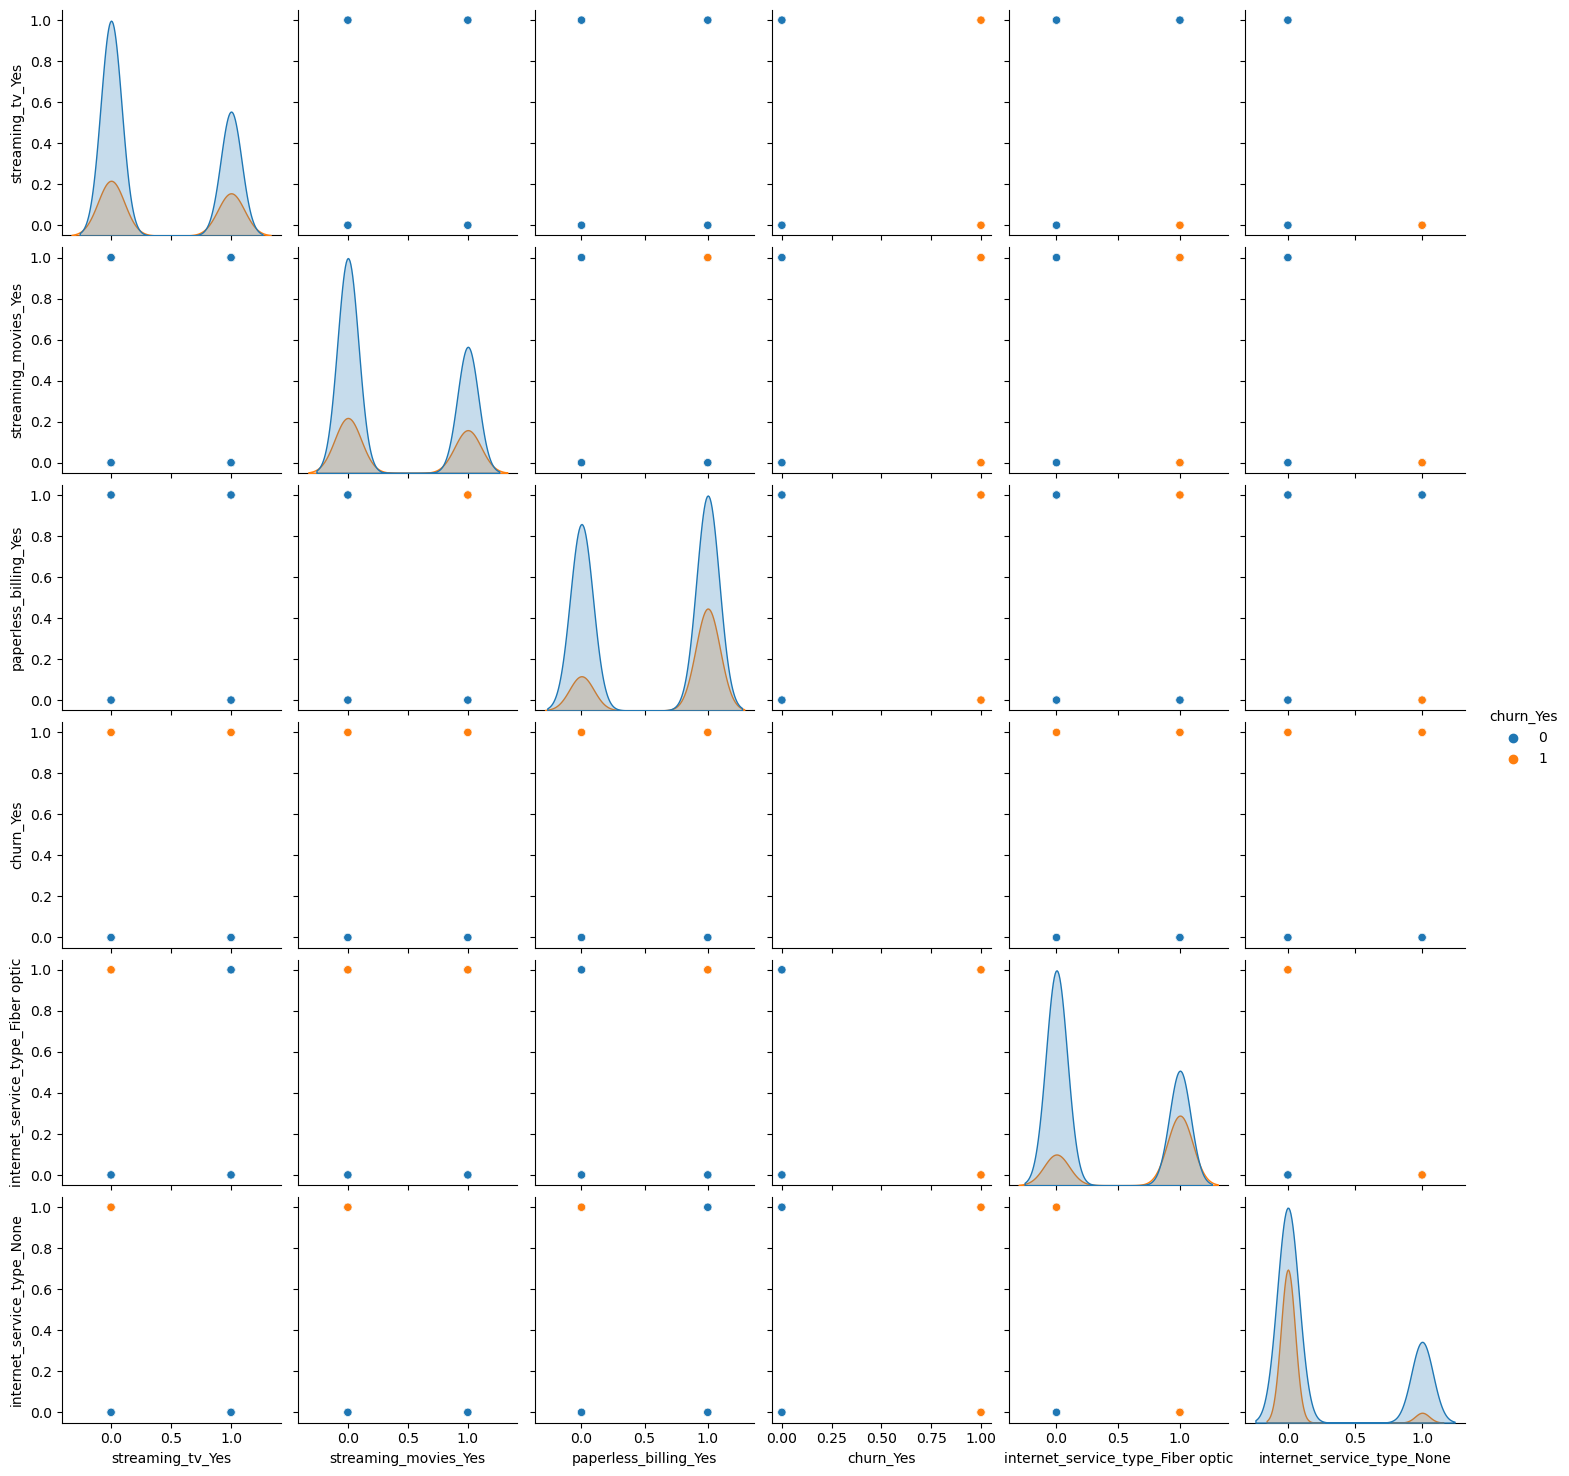

In [34]:
sns.pairplot(telco, x_vars = telco.columns[8:14], y_vars=telco.columns[8:14], hue='churn_Yes')

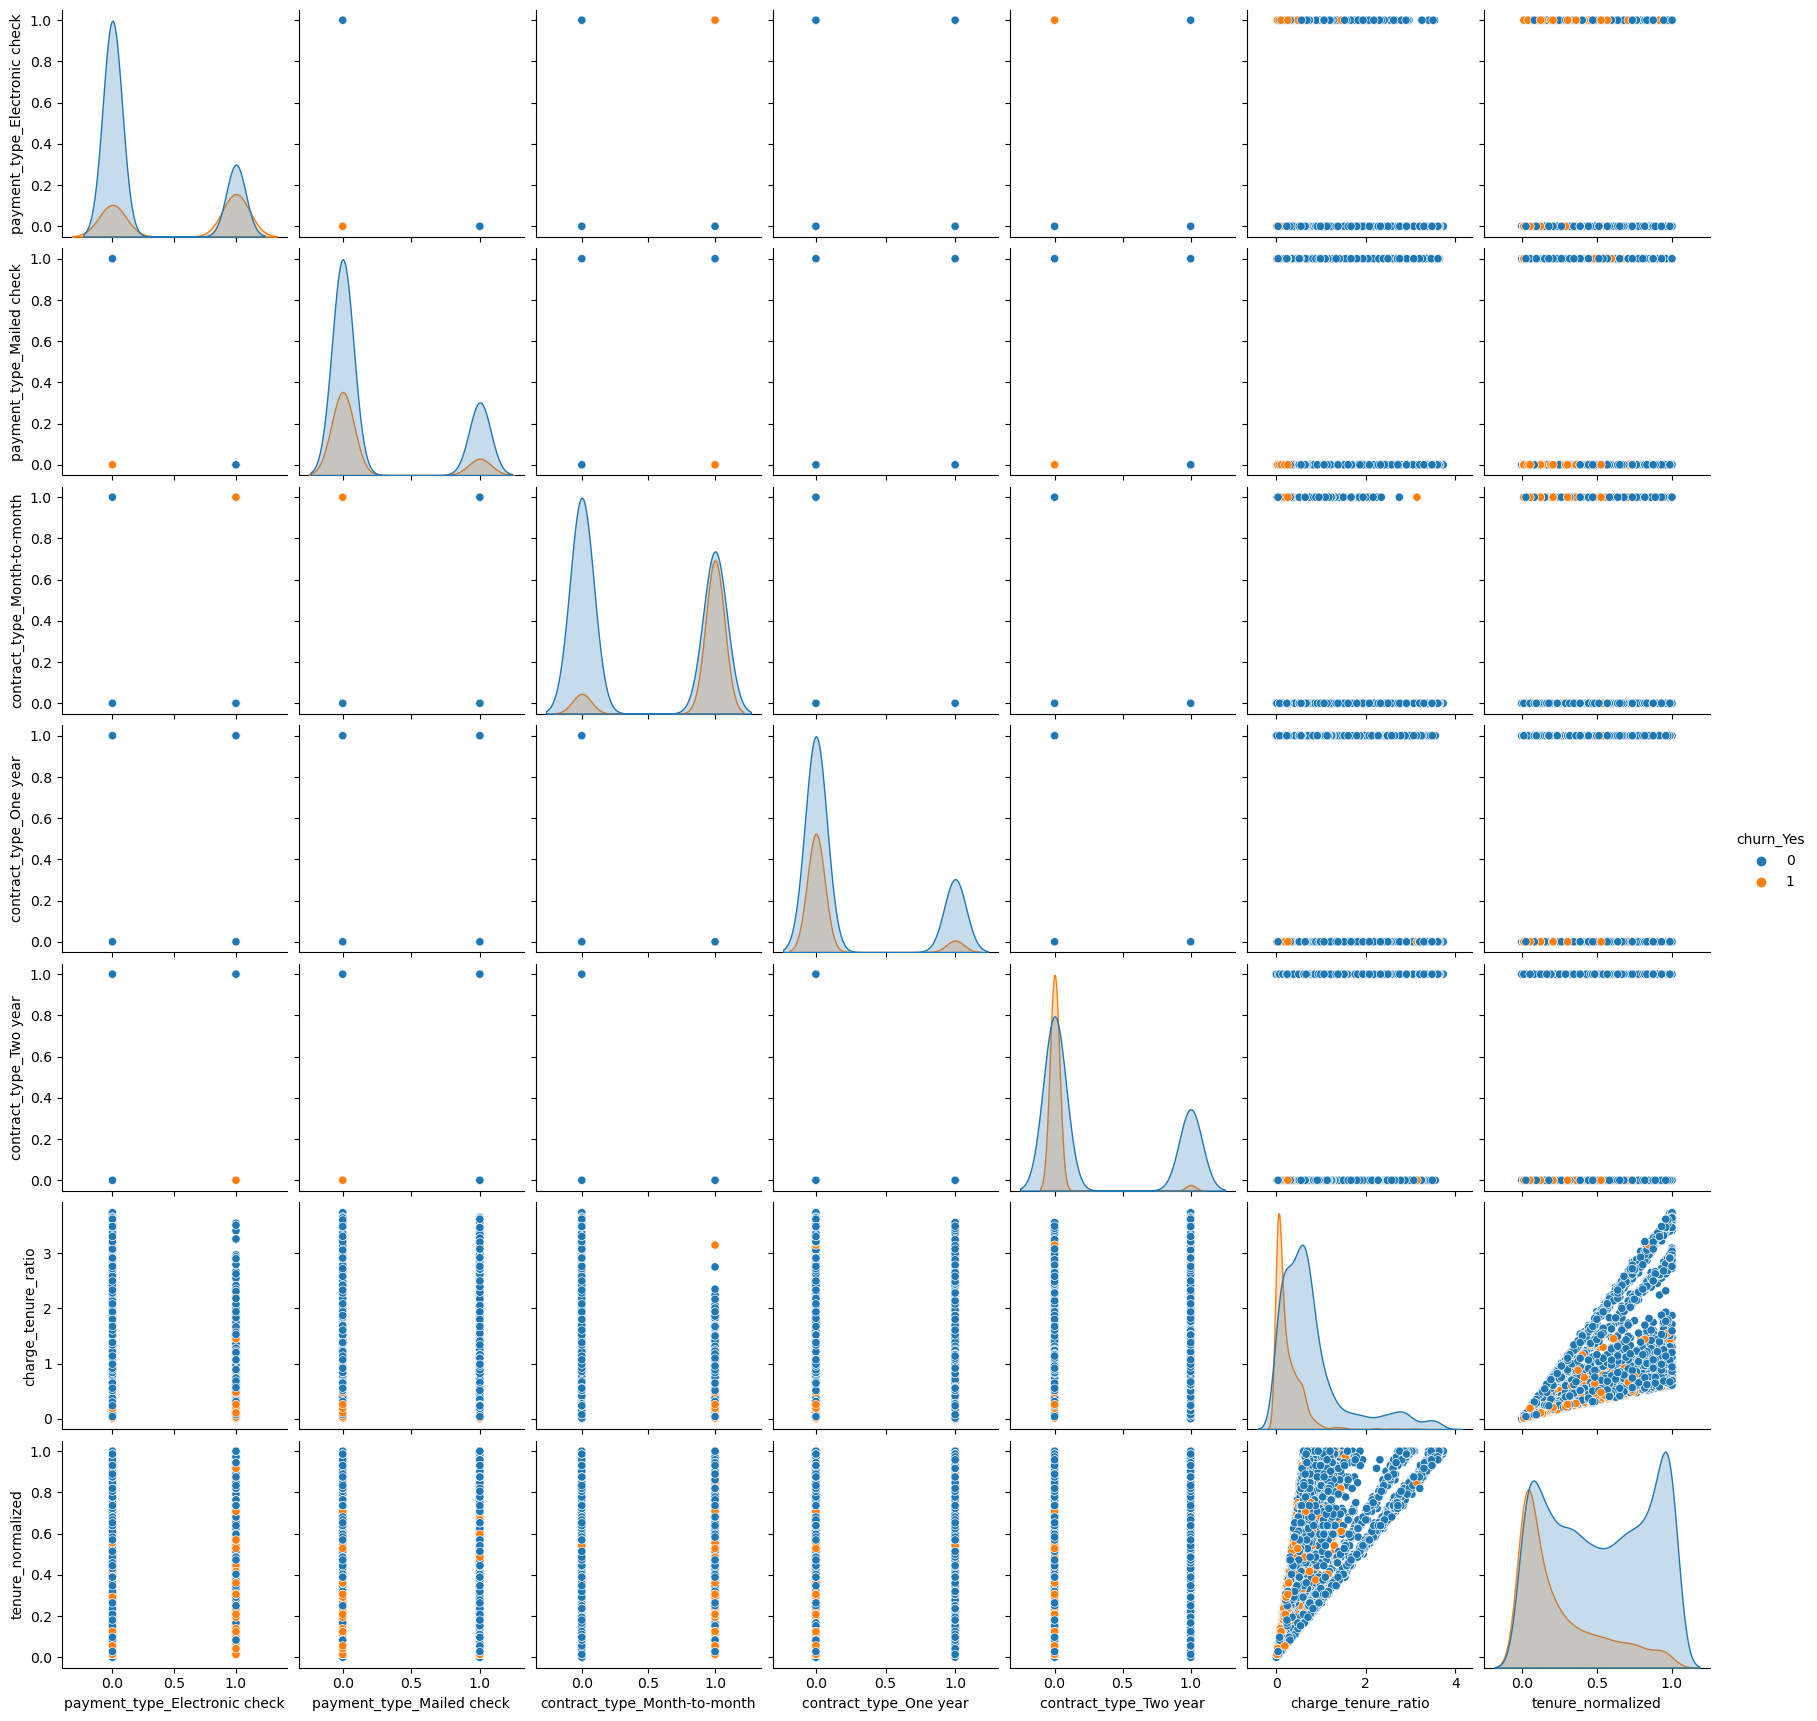

In [35]:
sns.pairplot(telco, x_vars = telco.columns[15:22], y_vars=telco.columns[15:22], hue='churn_Yes')

I performed this analysis before to see the dummy variable first column that was dropped.  Bringing this back should have no ulitmate impact on decision tree or random forest, outside of how the tree is labeled, but may have an impact on knn nearest neighbors especially since I am using manhattan coordinates.  Also it should add another layer to the logistic regression analysis which could theoretically help or hinder the result.  

In [27]:
telco_contract = telco[['contract_type_Month-to-month', 'contract_type_One year', 'contract_type_Two year', 'churn_Yes']]



In [28]:
month = pd.crosstab(telco['contract_type_Month-to-month'], telco['churn_Yes'])

In [29]:
chi2, p, degf, expected = stats.chi2_contingency(month)
chi2, p

(1153.9716611093477, 6.147585925549194e-253)

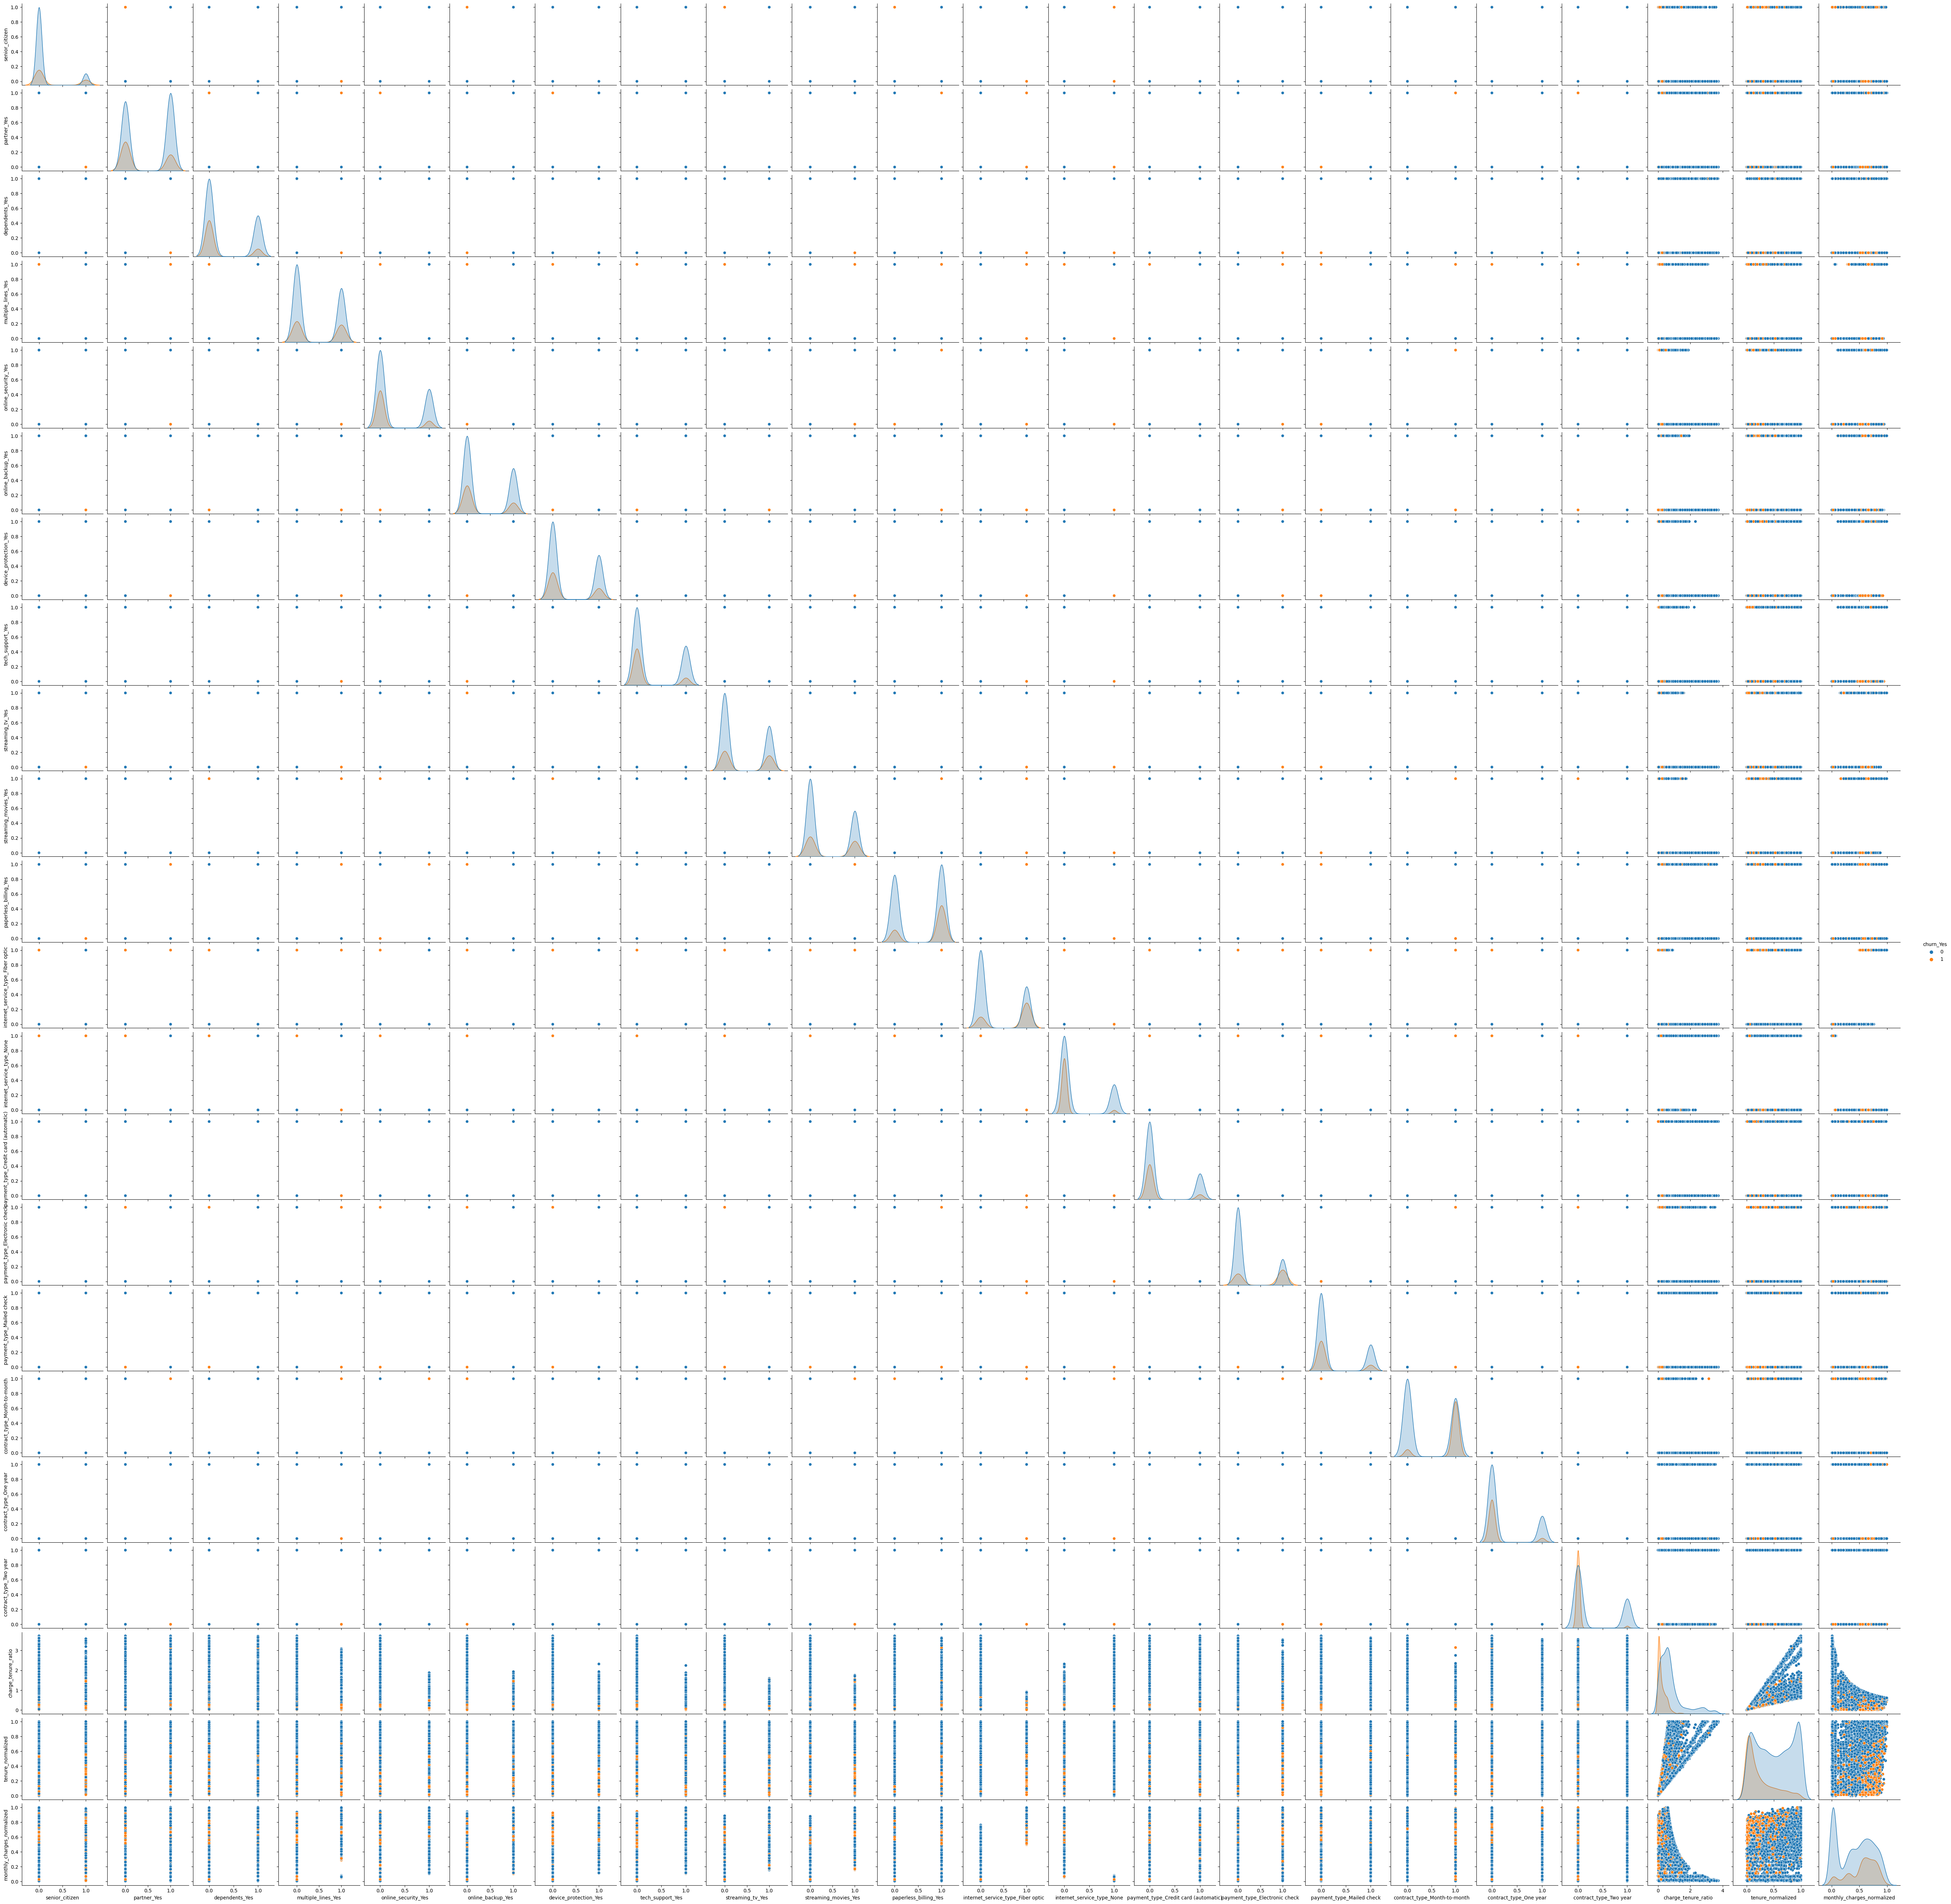

In [531]:
sns.pairplot(telco, hue='churn_Yes')

# Decision Tree

In [30]:
telco_string = telco
# telco = prepare.prep_telco()
# telco = telco.drop(columns=telco.select_dtypes(exclude='number').columns)
# telco = telco.astype('str')


In [31]:
telco_string.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   senior_citizen                        7043 non-null   int64  
 1   partner_Yes                           7043 non-null   uint8  
 2   dependents_Yes                        7043 non-null   uint8  
 3   multiple_lines_Yes                    7043 non-null   uint8  
 4   online_security_Yes                   7043 non-null   uint8  
 5   online_backup_Yes                     7043 non-null   uint8  
 6   device_protection_Yes                 7043 non-null   uint8  
 7   tech_support_Yes                      7043 non-null   uint8  
 8   streaming_tv_Yes                      7043 non-null   uint8  
 9   streaming_movies_Yes                  7043 non-null   uint8  
 10  paperless_billing_Yes                 7043 non-null   uint8  
 11  churn_Yes        

In [32]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_string, 'churn_Yes')

In [33]:
X_train.shape, X_validate.shape, X_test.shape

((4225, 22), (1409, 22), (1409, 22))

In [34]:
y_train.shape, y_validate.shape, y_test.shape

((4225,), (1409,), (1409,))

In [35]:
clf.classes_.astype('str')

NameError: name 'clf' is not defined

[0 0 0 0 0]


array([[0.63736264, 0.36263736],
       [0.63736264, 0.36263736],
       [0.63736264, 0.36263736],
       [0.83804627, 0.16195373],
       [0.96358543, 0.03641457]])

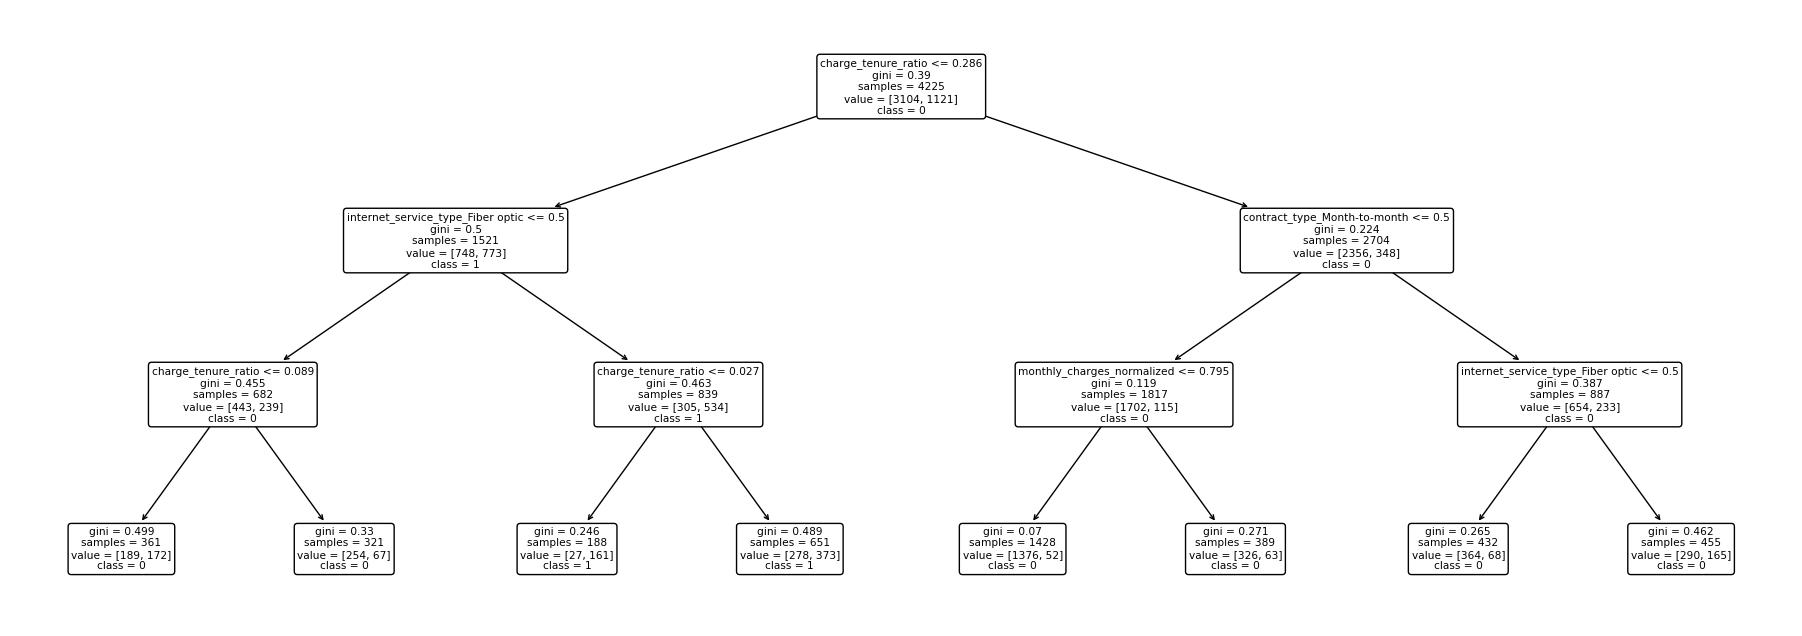

In [36]:
clf = DecisionTreeClassifier(max_depth=3, random_state=823)
clf = clf.fit(X_train, y_train)
plt.figure(figsize=(23, 8))
plot_tree(clf, feature_names=X_train.columns, class_names=clf.classes_.astype('str'), rounded=True)
y_pred = clf.predict(X_train)
print(y_pred[0:5])
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

In [37]:
print('Accuracy of Decision Tree classifier on training set: {:.8f}'
      .format(clf.score(X_train, y_train)))
print(confusion_matrix(y_train, y_pred))
print(y_train.value_counts())
labels = sorted(y_train.unique())
results = pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)
results

Accuracy of Decision Tree classifier on training set: 0.78887574
[[2799  305]
 [ 587  534]]
0    3104
1    1121
Name: churn_Yes, dtype: int64


0    1
0  2799  305
1   587  534

In [38]:
results[0][1]#/(results['0']['1']+results['1']['1'])  WHY THE HELL IS COLUMN AND ROW MIXED UP!

587

In [39]:
confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])

0.47636039250669043

In [40]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3104
           1       0.64      0.48      0.54      1121

    accuracy                           0.79      4225
   macro avg       0.73      0.69      0.70      4225
weighted avg       0.78      0.79      0.78      4225



In [41]:
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, random_state=823)
    clf = clf = clf.fit(X_train, y_train)
    #print(f'Accuracy of Decision Tree classifier on training set with depth {i}: {clf.score(X_train, y_train)})')
    #print(f'     Accuracy of Decision Tree classifier on validate set with depth {i}: {clf.score(X_validate, y_validate)})')
    print(f'Sensitivity of Decision Tree classifier on training set with depth {i}: {confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])}')

Sensitivity of Decision Tree classifier on training set with depth 1: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 2: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 3: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 4: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 5: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 6: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 7: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 8: 0.47636039250669043
Sensitivity of Decision Tree classifier on training set with depth 9: 0.47636039250669043


In [42]:
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, random_state=823)
    clf = clf = clf.fit(X_train, y_train)
    print(f'Accuracy Spread of Decision Tree classifier between train and validate with depth {i}: {clf.score(X_train, y_train) - clf.score(X_validate, y_validate)})')

Accuracy Spread of Decision Tree classifier between train and validate with depth 1: 0.018803213492300075)
Accuracy Spread of Decision Tree classifier between train and validate with depth 2: 0.015987166188618396)
Accuracy Spread of Decision Tree classifier between train and validate with depth 3: 0.015987166188618396)
Accuracy Spread of Decision Tree classifier between train and validate with depth 4: 0.021198970271416706)
Accuracy Spread of Decision Tree classifier between train and validate with depth 5: 0.037054270727907235)
Accuracy Spread of Decision Tree classifier between train and validate with depth 6: 0.04391951990794596)
Accuracy Spread of Decision Tree classifier between train and validate with depth 7: 0.06971195316666734)
Accuracy Spread of Decision Tree classifier between train and validate with depth 8: 0.08367611424443877)
Accuracy Spread of Decision Tree classifier between train and validate with depth 9: 0.09669588150562103)


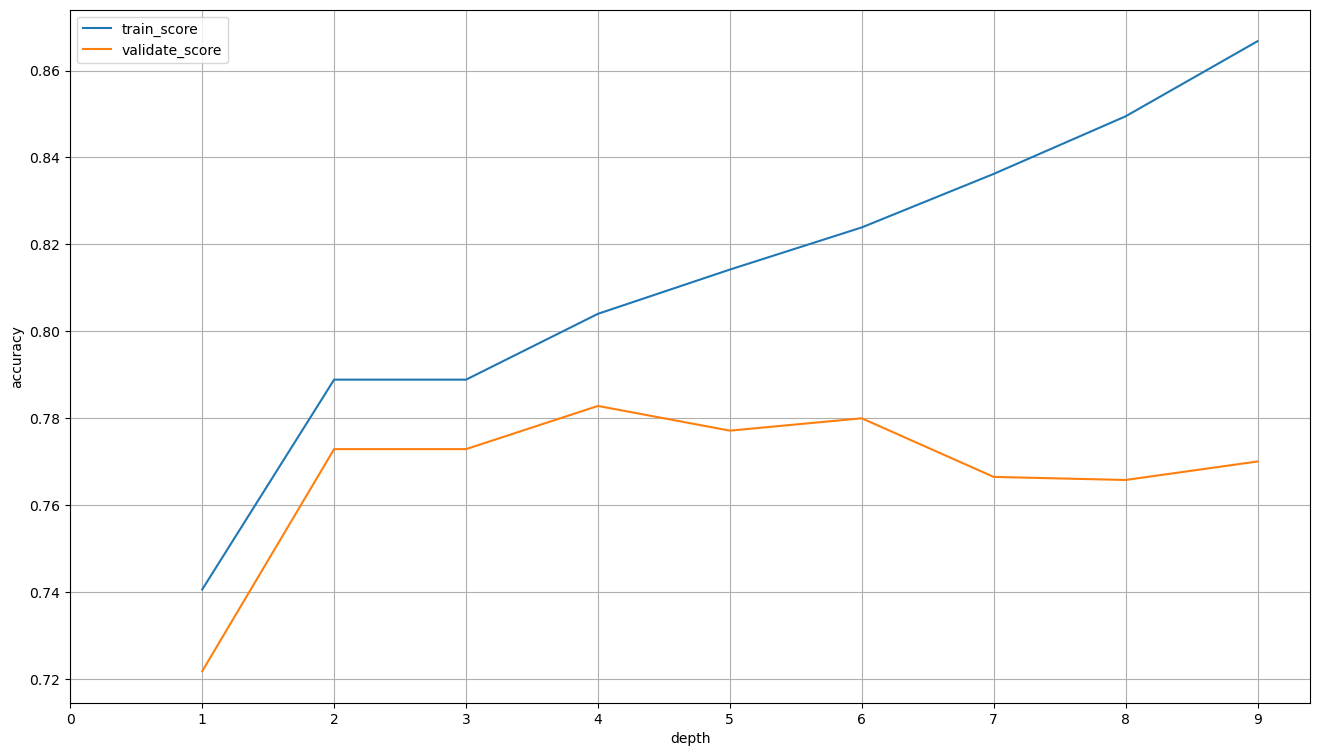

In [43]:
#FROM CLASS

metrics = []

for d in range(1,10):
    #Loops through the Decision Tree Classifier at each depth one through ten
    clf = DecisionTreeClassifier(max_depth=d, random_state=823)
    # Fits the data
    clf = clf = clf.fit(X_train, y_train)
    #Finds the train and validate accuracy scores
    train_score= clf.score(X_train, y_train)
    validate_score = clf.score(X_validate, y_validate)
    
    output = {
        "depth": d,
        "train_score": train_score,
        "validate_score": validate_score}
    
    metrics.append(output)
    
results = pd.DataFrame(metrics)

#Plots the results
results.set_index('depth').plot(figsize=(16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,10,1))
plt.grid()
plt.show()

# Random Forrest

In [44]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

In [45]:
rf = RandomForestClassifier(bootstrap=True,
                            class_weight=None,
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=18,
                            max_depth=8,
                            random_state=823)
rf.fit(X_train, y_train)
print(rf.feature_importances_)
y_pred = rf.predict(X_train)
print(y_pred[0:10])
y_pred_proba = rf.predict_proba(X_train)
print(y_pred_proba)
y_val = rf.predict(X_validate)
y_val_proba = rf.predict_proba(X_validate)

[0.00863103 0.01063269 0.01035647 0.01514524 0.01461095 0.01316006
 0.00648322 0.02228326 0.00890139 0.00780163 0.01875505 0.0517694
 0.02681534 0.00784077 0.05654419 0.00691545 0.15400066 0.01953369
 0.04892015 0.22214125 0.15859712 0.11016099]
[0 0 0 0 0 0 0 0 0 0]
[[0.53951899 0.46048101]
 [0.80233723 0.19766277]
 [0.61361259 0.38638741]
 ...
 [0.98111439 0.01888561]
 [0.87247082 0.12752918]
 [0.73584328 0.26415672]]


In [46]:
print(f'Sensitivity of Random Forrest on training set with 10 trees: {confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])}')

Sensitivity of Random Forrest on training set with 10 trees: 0.5744870651204282


In [47]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3104
           1       0.74      0.57      0.65      1121

    accuracy                           0.83      4225
   macro avg       0.80      0.75      0.77      4225
weighted avg       0.83      0.83      0.83      4225



In [48]:
print(confusion_matrix(y_validate, y_val))

[[930 105]
 [184 190]]


In [49]:
print(f'Sensitivity of Random Forrest on training set with 10 trees: {confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val)[1][1])}')

Sensitivity of Random Forrest on training set with 10 trees: 0.5080213903743316


In [50]:
print(classification_report(y_validate, y_val))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.64      0.51      0.57       374

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.79      1409



# KNN

In [51]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco, 'churn_Yes')

In [52]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=1)
knn5.fit(X_train, y_train)
y_pred5 = knn5.predict(X_train)
print(y_pred5[0:5])
y_pred_proba = knn5.predict_proba(X_train)
print(y_pred_proba[0:5])
knn5.classes_

[1 1 1 0 0]
[[0.2 0.8]
 [0.4 0.6]
 [0.4 0.6]
 [0.8 0.2]
 [1.  0. ]]


array([0, 1], dtype=uint8)

In [53]:
pd.crosstab(y_train, y_pred5)

col_0         0    1
churn_Yes           
0          2798  306
1           399  722

In [54]:
confusion_matrix(y_train, y_pred5)[1][1]/(confusion_matrix(y_train, y_pred5)[1][1]+confusion_matrix(y_train, y_pred5)[1][0])

0.6440677966101694

In [55]:
telco.describe()

senior_citizen  partner_Yes  dependents_Yes  multiple_lines_Yes  \
count     7043.000000  7043.000000     7043.000000         7043.000000   
mean         0.162147     0.483033        0.299588            0.421837   
std          0.368612     0.499748        0.458110            0.493888   
min          0.000000     0.000000        0.000000            0.000000   
25%          0.000000     0.000000        0.000000            0.000000   
50%          0.000000     0.000000        0.000000            0.000000   
75%          0.000000     1.000000        1.000000            1.000000   
max          1.000000     1.000000        1.000000            1.000000   

       online_security_Yes  online_backup_Yes  device_protection_Yes  \
count          7043.000000        7043.000000            7043.000000   
mean              0.286668           0.344881               0.343888   
std               0.452237           0.475363               0.475038   
min               0.000000           0.000000               0.000000   
25%               0.000000           0.000000               0.000000   
50%               0.000000           0.000000               0.000000   
75%               1.000000           1.000000               1.000000   
max               1.000000           1.000000               1.000000   

       tech_support_Yes  streaming_tv_Yes  streaming_movies_Yes  ...  \
count       7043.000000       7043.000000           7043.000000  ...   
mean           0.290217          0.384353              0.387903  ...   
std            0.453895          0.486477              0.487307  ...   
min            0.000000          0.000000              0.000000  ...   
25%            0.000000          0.000000              0.000000  ...   
50%            0.000000          0.000000              0.000000  ...   
75%            1.000000          1.000000              1.000000  ...   
max            1.000000          1.000000              1.000000  ...   

       internet_service_type_None  payment_type_Credit card (automatic)  \
count                 7043.000000                           7043.000000   
mean                     0.216669                              0.216101   
std                      0.412004                              0.411613   
min                      0.000000                              0.000000   
25%                      0.000000                              0.000000   
50%                      0.000000                              0.000000   
75%                      0.000000                              0.000000   
max                      1.000000                              1.000000   

       payment_type_Electronic check  payment_type_Mailed check  \
count                    7043.000000                7043.000000   
mean                        0.335794                   0.228880   
std                         0.472301                   0.420141   
min                         0.000000                   0.000000   
25%                         0.000000                   0.000000   
50%                         0.000000                   0.000000   
75%                         1.000000                   0.000000   
max                         1.000000                   1.000000   

       contract_type_Month-to-month  contract_type_One year  \
count                   7043.000000             7043.000000   
mean                       0.550192                0.209144   
std                        0.497510                0.406726   
min                        0.000000                0.000000   
25%                        0.000000                0.000000   
50%                        1.000000                0.000000   
75%                        1.000000                0.000000   
max                        1.000000                1.000000   

       contract_type_Two year  charge_tenure_ratio  tenure_normalized  \
count             7043.000000          7043.000000        7043.000000   
mean                 0.240664             0.6488

In [56]:
y_pred = knn5.predict(X_train)
print(y_pred[0:5])
y_pred_proba = knn5.predict_proba(X_train)
y_pred_proba[0:5]
print(confusion_matrix(y_train, y_pred))
y_val = knn5.predict(X_validate)
y_val_proba = knn5.predict_proba(X_validate)

[1 1 1 0 0]
[[2798  306]
 [ 399  722]]


In [57]:
print(f'Sensitivity of Decision Tree classifier on training set with depth {i}: {confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred)[1][1])}')

Sensitivity of Decision Tree classifier on training set with depth 9: 0.6440677966101694


In [58]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3104
           1       0.70      0.64      0.67      1121

    accuracy                           0.83      4225
   macro avg       0.79      0.77      0.78      4225
weighted avg       0.83      0.83      0.83      4225



In [59]:
print(confusion_matrix(y_validate, y_val))

[[892 143]
 [168 206]]


In [60]:
print(f'Sensitivity of KNN on training set with i neighbors: {confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val)[1][1])}')

Sensitivity of KNN on training set with i neighbors: 0.5508021390374331


In [61]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    y_val = knn.predict(X_validate)
    y_val_proba = knn.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121)
    }

In [62]:
model_set

[KNeighborsClassifier(n_neighbors=1, p=1),
 KNeighborsClassifier(n_neighbors=2, p=1),
 KNeighborsClassifier(n_neighbors=3, p=1),
 KNeighborsClassifier(n_neighbors=4, p=1),
 KNeighborsClassifier(p=1),
 KNeighborsClassifier(n_neighbors=6, p=1),
 KNeighborsClassifier(n_neighbors=7, p=1),
 KNeighborsClassifier(n_neighbors=8, p=1),
 KNeighborsClassifier(n_neighbors=9, p=1),
 KNeighborsClassifier(n_neighbors=10, p=1),
 KNeighborsClassifier(n_neighbors=11, p=1),
 KNeighborsClassifier(n_neighbors=12, p=1),
 KNeighborsClassifier(n_neighbors=13, p=1),
 KNeighborsClassifier(n_neighbors=14, p=1),
 KNeighborsClassifier(n_neighbors=15, p=1),
 KNeighborsClassifier(n_neighbors=16, p=1),
 KNeighborsClassifier(n_neighbors=17, p=1),
 KNeighborsClassifier(n_neighbors=18, p=1),
 KNeighborsClassifier(n_neighbors=19, p=1)]

In [63]:
model_accuracies

{'1 neighbors': {'train_score': 0.99669,
  'validate_score': 0.73101,
  'Sensitivity_train': 0.99554,
  'Sensitivity_validate': 0.50267,
  'Sensitivity_difference': 0.49287000000000003,
  'Just_for_analysis_TP': 0.9971005154639175,
  'Just_for_analysis_TP_val': 0.7511150758251561},
 '2 neighbors': {'train_score': 0.87172,
  'validate_score': 0.77218,
  'Sensitivity_train': 0.5165,
  'Sensitivity_validate': 0.36096,
  'Sensitivity_difference': 0.15553999999999996,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.8501338090990187},
 '3 neighbors': {'train_score': 0.85988,
  'validate_score': 0.76082,
  'Sensitivity_train': 0.69581,
  'Sensitivity_validate': 0.55615,
  'Sensitivity_difference': 0.13966,
  'Just_for_analysis_TP': 0.9191365979381443,
  'Just_for_analysis_TP_val': 0.7707404103479036},
 '4 neighbors': {'train_score': 0.83716,
  'validate_score': 0.77289,
  'Sensitivity_train': 0.49509,
  'Sensitivity_validate': 0.40642,
  'Sensitivity_difference': 0.088669999999

In [64]:
pd.DataFrame(model_accuracies).T

train_score  validate_score  Sensitivity_train  \
1 neighbors       0.99669         0.73101            0.99554   
2 neighbors       0.87172         0.77218            0.51650   
3 neighbors       0.85988         0.76082            0.69581   
4 neighbors       0.83716         0.77289            0.49509   
5 neighbors       0.83314         0.77928            0.64407   
6 neighbors       0.82888         0.78779            0.52453   
7 neighbors       0.82107         0.78282            0.61998   
8 neighbors       0.82178         0.79702            0.53880   
9 neighbors       0.81112         0.79063            0.60303   
10 neighbors      0.81420         0.79702            0.53256   
11 neighbors      0.81065         0.78637            0.60393   
12 neighbors      0.81444         0.79347            0.54683   
13 neighbors      0.81089         0.78708            0.60660   
14 neighbors      0.80947         0.79063            0.54148   
15 neighbors      0.81231         0.78282            0.60839   
16 neighbors      0.81231         0.78779            0.56735   
17 neighbors      0.80994         0.78424            0.61731   
18 neighbors      0.80947         0.78850            0.57627   
19 neighbors      0.80828         0.77999            0.61909   

              Sensitivity_validate  Sensitivity_difference  \
1 neighbors                0.50267                 0.49287   
2 neighbors                0.36096                 0.15554   
3 neighbors                0.55615                 0.13966   
4 neighbors                0.40642                 0.08867   
5 neighbors                0.55080                 0.09327   
6 neighbors                0.45989                 0.06464   
7 neighbors                0.54545                 0.07453   
8 neighbors                0.52139                 0.01741   
9 neighbors                0.58289                 0.02014   
10 neighbors               0.54011                -0.00755   
11 neighbors               0.57754                 0.02639   
12 neighbors               0.53476                 0.01207   
13 neighbors               0.58289                 0.02371   
14 neighbors               0.53743                 0.00405   
15 neighbors               0.58021                 0.02818   
16 neighbors               0.54813                 0.01922   
17 neighbors               0.57754                 0.03977   
18 neighbors               0.55615                 0.02012   
19 neighbors               0.57487                 0.04422   

              Just_for_analysis_TP  Just_for_analysis_TP_val  
1 neighbors               0.997101                  0.751115  
2 neighbors               1.000000                  0.850134  
3 neighbors               0.919137                  0.770740  
4 neighbors               0.960696                  0.835861  
5 neighbors               0.901418                  0.795718  
6 neighbors               0.938789                  0.836753  
7 neighbors               0.893686                  0.801963  
8 neighbors               0.923969                  0.827832  
9 neighbors               0.886276                  0.799286  
10 neighbors              0.915915                  0.821588  
11 neighbors              0.885309                  0.795718  
12 neighbors              0.911082                  0.818912  
13 neighbors              0.884665                  0.794826  
14 neighbors              0.906250                  0.814451  
15 neighbors              0.885954                  0.790366  
16 neighbors              0.900773                  0.807315  
17 neighbors              0.879510                  0.793042  
18 neighbors              0.893686                  0.805531  
19 neighbors              0.876611                  0.788582

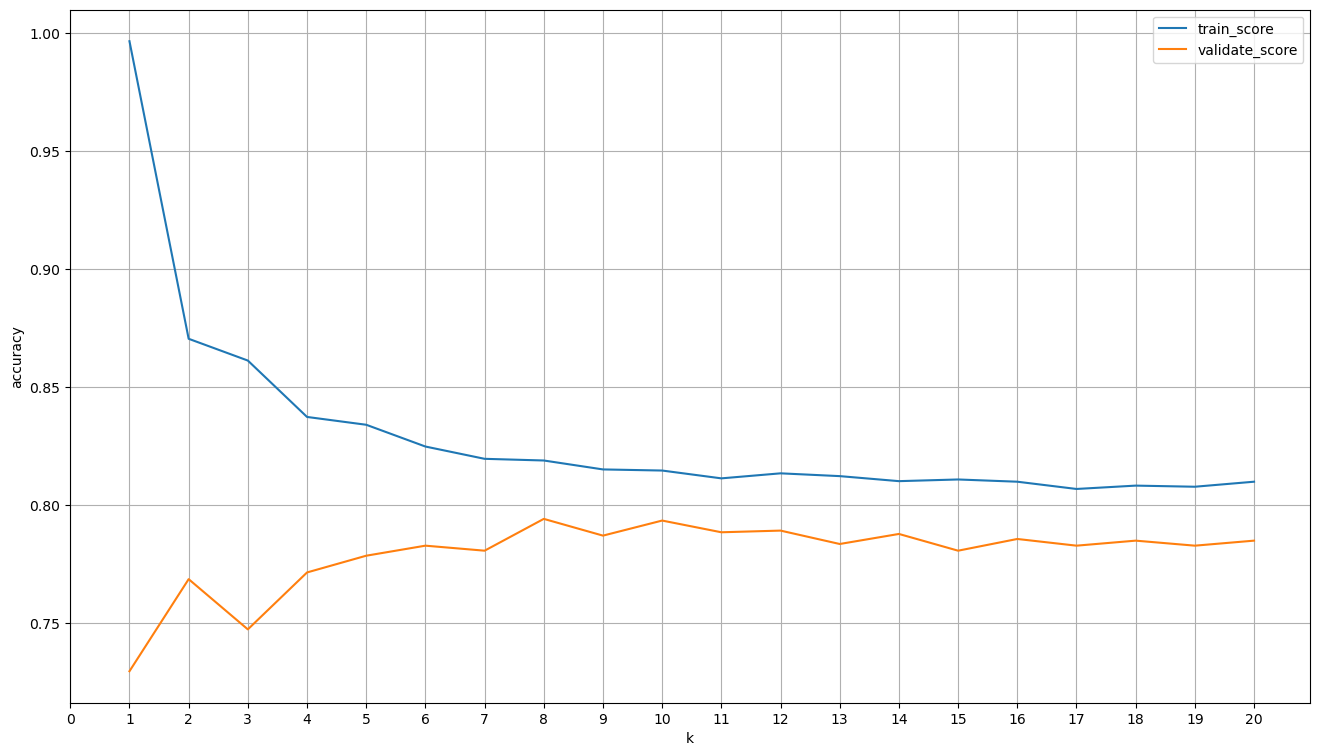

In [65]:
metrics = []

# Loops through the different values one through twenty
for k in range(1,21):
    #Classifies the nearest neighbors and runs all the KNN for one neighbor through 20 neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    # Fits the data
    knn.fit(X_train, y_train)
    # Gets the accuracies each of the train and validate sets for all the loops
    train_score= knn.score(X_train, y_train)
    validate_score = knn.score(X_validate, y_validate)
    
    output = {
        "k": k,
        "train_score": train_score,
        "validate_score": validate_score}
    
    metrics.append(output)
    
results = pd.DataFrame(metrics)

#plots the resuots
results.set_index('k').plot(figsize=(16,9))
plt.ylabel('accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()

In [66]:
#telco_knn = prepare.prep_telco_alternative()
telco_knn = telco
telco_knn

senior_citizen  partner_Yes  dependents_Yes  multiple_lines_Yes  \
0                  0            1               1                   0   
1                  0            0               0                   1   
2                  0            0               0                   0   
3                  1            1               0                   0   
4                  1            1               0                   0   
...              ...          ...             ...                 ...   
7038               0            0               0                   0   
7039               0            1               0                   1   
7040               0            0               0                   0   
7041               0            1               1                   0   
7042               0            1               1                   0   

      online_security_Yes  online_backup_Yes  device_protection_Yes  \
0                       0                  1                      0   
1                       0                  0                      0   
2                       0                  0                      1   
3                       0                  1                      1   
4                       0                  0                      0   
...                   ...                ...                    ...   
7038                    1                  0                      0   
7039                    0                  0                      0   
7040                    0                  1                      0   
7041                    1                  0                      1   
7042                    1                  1                      1   

      tech_support_Yes  streaming_tv_Yes  streaming_movies_Yes  ...  \
0                    1                 1                     0  ...   
1                    0                 0                     1  ...   
2                    0                 0                     0  ...   
3                    0                 1                     1  ...   
4                    1                 1                     0  ...   
...                ...               ...                   ...  ...   
7038                 1                 0                     0  ...   
7039                 0                 0                     1  ...   
7040                 0                 0                     0  ...   
7041                 1                 0                     1  ...   
7042                 0                 1                     1  ...   

      internet_service_type_None  payment_type_Credit card (automatic)  \
0                              0                                     0   
1                              0                                     0   
2                              0                                     0   
3                              0                                     0   
4                              0                                     0   
...                          ...                                   ...   
7038                           0                                     0   
7039                           0                                     0   
7040                           0                                     0   
7041                           0                                     0   
7042                           0                                     0   

      payment_type_Electronic check  payment_type_Mailed check  \
0                                 0                          1   
1                                 0                          1   
2                                 1                          0   
3                                 1                          0   
4                                 0                          1   
...                             ...                        ...   
7038                              0                          1   
7039  

In [67]:
telco_knn.columns

Index(['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes',
       'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes',
       'tech_support_Yes', 'streaming_tv_Yes', 'streaming_movies_Yes',
       'paperless_billing_Yes', 'churn_Yes',
       'internet_service_type_Fiber optic', 'internet_service_type_None',
       'payment_type_Credit card (automatic)', 'payment_type_Electronic check',
       'payment_type_Mailed check', 'contract_type_Month-to-month',
       'contract_type_One year', 'contract_type_Two year',
       'charge_tenure_ratio', 'tenure_normalized',
       'monthly_charges_normalized'],
      dtype='object')

In [68]:
telco_knn['senior_citizen'] = telco_knn['senior_citizen'].replace([0,1], [1,0])
telco_knn['partner_Yes'] = telco_knn['partner_Yes'].replace([0,1], [1,0])
telco_knn['dependents_Yes'] = telco_knn['dependents_Yes'].replace([0,1], [1,0])
telco_knn['multiple_lines_Yes'] = telco_knn['multiple_lines_Yes'].replace([0,1], [1,0])
telco_knn['online_security_Yes'] = telco_knn['online_security_Yes'].replace([0,1], [1,0])
telco_knn['online_backup_Yes'] = telco_knn['online_backup_Yes'].replace([0,1], [1,0])
telco_knn['device_protection_Yes'] = telco_knn['device_protection_Yes'].replace([0,1], [1,0])
telco_knn['tech_support_Yes'] = telco_knn['tech_support_Yes'].replace([0,1], [1,0])
telco_knn['internet_service_type_Fiber optic'] = telco_knn['internet_service_type_Fiber optic'].replace([0,1], [1,0])
telco_knn['internet_service_type_None'] = telco_knn['internet_service_type_None'].replace([0,1], [1,0])
telco_knn['payment_type_Mailed check'] = telco_knn['payment_type_Mailed check'].replace([0,1], [1,0])
telco_knn['contract_type_One year'] = telco_knn['contract_type_One year'].replace([0,1], [1,0])
telco_knn['contract_type_Two year'] = telco_knn['contract_type_Two year'].replace([0,1], [1,0])
telco_knn['tenure_normalized'] = telco_knn['tenure_normalized'].replace([0,1], [1,0])

In [69]:
telco_knn = telco_knn.drop(columns=['senior_citizen', 'partner_Yes', 'dependents_Yes', 'multiple_lines_Yes', 'online_security_Yes', 'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes', 'payment_type_Credit card (automatic)', 'payment_type_Mailed check'])

In [70]:
telco_knn = telco_knn.drop(columns=['streaming_tv_Yes', 'streaming_movies_Yes', 'monthly_charges_normalized'])

In [71]:
telco_knn = telco_knn.drop(columns=['Unnamed: 0'])

KeyError: "['Unnamed: 0'] not found in axis"

In [72]:
telco_knn

paperless_billing_Yes  churn_Yes  internet_service_type_Fiber optic  \
0                         1          0                                  1   
1                         0          0                                  1   
2                         1          1                                  0   
3                         1          1                                  0   
4                         1          1                                  0   
...                     ...        ...                                ...   
7038                      0          0                                  1   
7039                      1          1                                  0   
7040                      1          0                                  1   
7041                      0          0                                  1   
7042                      0          0                                  1   

      internet_service_type_None  payment_type_Electronic check  \
0                              1                              0   
1                              1                              0   
2                              1                              1   
3                              1                              1   
4                              1                              0   
...                          ...                            ...   
7038                           1                              0   
7039                           1                              1   
7040                           1                              0   
7041                           1                              0   
7042                           1                              1   

      contract_type_Month-to-month  contract_type_One year  \
0                                0                       0   
1                                1                       1   
2                                1                       1   
3                                1                       1   
4                                1                       1   
...                            ...                     ...   
7038                             0                       0   
7039                             1                       1   
7040                             1                       1   
7041                             0                       1   
7042                             0                       1   

      contract_type_Two year  charge_tenure_ratio  tenure_normalized  
0                          1             0.137195           0.125000  
1                          1             0.150250           0.125000  
2                          1             0.054127           0.055556  
3                          1             0.132653           0.180556  
4                          1             0.035757           0.041667  
...                      ...                  ...                ...  
7038                       1             0.235721           0.180556  
7039                       1             0.258519           0.305556  
7040                       1             0.039761           0.027778  
7041                       0             0.987472           0.930556  
7042                       0             1.067797           0.875000  

[7043 rows x 10 columns]

In [73]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_knn, 'churn_Yes')

In [74]:
knn5 = KNeighborsClassifier(n_neighbors=5, weights='distance', p=1)
knn5.fit(X_train, y_train)
y_pred5 = knn5.predict(X_train)
print(y_pred5[0:5])
y_pred_proba = knn5.predict_proba(X_train)
print(y_pred_proba[0:5])
knn5.classes_

[0 0 1 0 0]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


array([0, 1], dtype=uint8)

In [75]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)

    y_val = knn.predict(X_validate)
    y_val_proba = knn.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
   

    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121)
        
        
    }

In [76]:
model_set

[KNeighborsClassifier(n_neighbors=1, p=1),
 KNeighborsClassifier(n_neighbors=2, p=1),
 KNeighborsClassifier(n_neighbors=3, p=1),
 KNeighborsClassifier(n_neighbors=4, p=1),
 KNeighborsClassifier(p=1),
 KNeighborsClassifier(n_neighbors=6, p=1),
 KNeighborsClassifier(n_neighbors=7, p=1),
 KNeighborsClassifier(n_neighbors=8, p=1),
 KNeighborsClassifier(n_neighbors=9, p=1),
 KNeighborsClassifier(n_neighbors=10, p=1),
 KNeighborsClassifier(n_neighbors=11, p=1),
 KNeighborsClassifier(n_neighbors=12, p=1),
 KNeighborsClassifier(n_neighbors=13, p=1),
 KNeighborsClassifier(n_neighbors=14, p=1),
 KNeighborsClassifier(n_neighbors=15, p=1),
 KNeighborsClassifier(n_neighbors=16, p=1),
 KNeighborsClassifier(n_neighbors=17, p=1),
 KNeighborsClassifier(n_neighbors=18, p=1),
 KNeighborsClassifier(n_neighbors=19, p=1)]

In [77]:
model_accuracies

{'1 neighbors': {'train_score': 0.99314,
  'validate_score': 0.72463,
  'Sensitivity_train': 0.9884,
  'Sensitivity_validate': 0.47861,
  'Sensitivity_difference': 0.50979,
  'Just_for_analysis_TP': 0.9948453608247423,
  'Just_for_analysis_TP_val': 0.7511150758251561},
 '2 neighbors': {'train_score': 0.86911,
  'validate_score': 0.76153,
  'Sensitivity_train': 0.50669,
  'Sensitivity_validate': 0.30481,
  'Sensitivity_difference': 0.20187999999999995,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.855486173059768},
 '3 neighbors': {'train_score': 0.86296,
  'validate_score': 0.75869,
  'Sensitivity_train': 0.68243,
  'Sensitivity_validate': 0.48663,
  'Sensitivity_difference': 0.19579999999999997,
  'Just_for_analysis_TP': 0.9281572164948454,
  'Just_for_analysis_TP_val': 0.7912578055307761},
 '4 neighbors': {'train_score': 0.84237,
  'validate_score': 0.7736,
  'Sensitivity_train': 0.51918,
  'Sensitivity_validate': 0.38235,
  'Sensitivity_difference': 0.13682999999999

In [210]:
df['column name'] = df['column name'].replace(['1st old value', '2nd old value', ...], ['1st new value', '2nd new value', ...])

NameError: name 'df' is not defined

# Logistic Regression

In [78]:
telco_knn

paperless_billing_Yes  churn_Yes  internet_service_type_Fiber optic  \
0                         1          0                                  1   
1                         0          0                                  1   
2                         1          1                                  0   
3                         1          1                                  0   
4                         1          1                                  0   
...                     ...        ...                                ...   
7038                      0          0                                  1   
7039                      1          1                                  0   
7040                      1          0                                  1   
7041                      0          0                                  1   
7042                      0          0                                  1   

      internet_service_type_None  payment_type_Electronic check  \
0                              1                              0   
1                              1                              0   
2                              1                              1   
3                              1                              1   
4                              1                              0   
...                          ...                            ...   
7038                           1                              0   
7039                           1                              1   
7040                           1                              0   
7041                           1                              0   
7042                           1                              1   

      contract_type_Month-to-month  contract_type_One year  \
0                                0                       0   
1                                1                       1   
2                                1                       1   
3                                1                       1   
4                                1                       1   
...                            ...                     ...   
7038                             0                       0   
7039                             1                       1   
7040                             1                       1   
7041                             0                       1   
7042                             0                       1   

      contract_type_Two year  charge_tenure_ratio  tenure_normalized  
0                          1             0.137195           0.125000  
1                          1             0.150250           0.125000  
2                          1             0.054127           0.055556  
3                          1             0.132653           0.180556  
4                          1             0.035757           0.041667  
...                      ...                  ...                ...  
7038                       1             0.235721           0.180556  
7039                       1             0.258519           0.305556  
7040                       1             0.039761           0.027778  
7041                       0             0.987472           0.930556  
7042                       0             1.067797           0.875000  

[7043 rows x 10 columns]

In [84]:
model_set = []
model_accuracies = {}

for i in range(-3,3):
    logit = LogisticRegression(C=10**i, random_state=823, intercept_scaling=1, max_iter=1000, solver='lbfgs')
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_train)
    y_pred_proba = logit.predict_proba(X_train)
        
    y_val = logit.predict(X_validate)
    y_val_proba = logit.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    model_set.append(logit)
    model_accuracies[f'$10^{i}$'] = {
        'train_score' : round(logit.score(X_train, y_train), 5),
        'validate_score' : round(logit.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121),
    }




In [85]:
model_set 

[LogisticRegression(C=0.001, max_iter=1000, random_state=823),
 LogisticRegression(C=0.01, max_iter=1000, random_state=823),
 LogisticRegression(C=0.1, max_iter=1000, random_state=823),
 LogisticRegression(C=1, max_iter=1000, random_state=823),
 LogisticRegression(C=10, max_iter=1000, random_state=823),
 LogisticRegression(C=100, max_iter=1000, random_state=823)]

In [86]:
model_accuracies

{'$10^-3$': {'train_score': 0.73467,
  'validate_score': 0.73456,
  'Sensitivity_train': 0.0,
  'Sensitivity_validate': 0.0,
  'Sensitivity_difference': 0.0,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.9232827832292596},
 '$10^-2$': {'train_score': 0.7903,
  'validate_score': 0.77573,
  'Sensitivity_train': 0.37556,
  'Sensitivity_validate': 0.37701,
  'Sensitivity_difference': -0.0014500000000000068,
  'Just_for_analysis_TP': 0.9400773195876289,
  'Just_for_analysis_TP_val': 0.8492417484388939},
 '$10^-1$': {'train_score': 0.79858,
  'validate_score': 0.77715,
  'Sensitivity_train': 0.51829,
  'Sensitivity_validate': 0.48396,
  'Sensitivity_difference': 0.03433000000000003,
  'Just_for_analysis_TP': 0.8998067010309279,
  'Just_for_analysis_TP_val': 0.8153434433541481},
 '$10^0$': {'train_score': 0.79787,
  'validate_score': 0.78211,
  'Sensitivity_train': 0.53434,
  'Sensitivity_validate': 0.5107,
  'Sensitivity_difference': 0.023639999999999994,
  'Just_for_analysi

model_set

In [214]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)
odds = np.exp(logit.coef_)
odds

Coefficient: 
 [[-0.22838244  0.01552194  0.06981038 -0.54269076  0.22957814 -0.15981688
  -0.35860886  0.13844892  0.7168109   0.45518499  0.4526223  -2.02892128
   1.65516995 -0.03851968  0.3083868   0.04139096  0.73369062 -0.14373916
   1.0739619  -3.04977113 -0.78891237 -4.53837883]]
Intercept: 
 [0.17652849]


array([[0.79581984, 1.01564303, 1.07230483, 0.58118232, 1.25806917,
        0.85229984, 0.69864756, 1.14849101, 2.04789186, 1.57646499,
        1.57243017, 0.13147727, 5.23396937, 0.96221277, 1.36122741,
        1.04225951, 2.08275308, 0.86611364, 2.92695285, 0.04736976,
        0.45433868, 0.01069072]])

In [215]:
y_pred = logit.predict(X_train)
print(y_pred)
y_pred_proba = logit.predict_proba(X_train)
print(y_pred_proba)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))
print(confusion_matrix(y_train, y_pred))
print(classification_report(y_train, y_pred))

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- dependents_Yes
- device_protection_Yes
- monthly_charges_normalized
- multiple_lines_Yes
- online_backup_Yes
- ...


In [216]:
print(y_pred_proba)

[[0.68421053 0.31578947]
 [0.63157895 0.36842105]
 [0.63157895 0.36842105]
 ...
 [1.         0.        ]
 [0.94736842 0.05263158]
 [0.78947368 0.21052632]]


In [217]:
pd.set_option('display.max_rows', None)
print(y_pred)

[0 0 0 ... 0 0 0]


In [218]:
telco_slice  = telco[telco.charge_tenure_ratio <= .5]

In [219]:
telco_slice.churn_Yes.value_counts()

0    2151
1    1577
Name: churn_Yes, dtype: int64

In [220]:
telco.churn_Yes.value_counts()

0    5174
1    1869
Name: churn_Yes, dtype: int64

In [123]:
X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.split_data_label(telco_slice, 'churn_Yes')

In [221]:
model_set = []
model_accuracies = {}

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform', p=1)
    knn.fit(X_train, y_train)
    
    y_pred = knn.predict(X_train)
    y_pred_proba = knn.predict_proba(X_train)
    
    y_val = knn.predict(X_validate)
    y_val_proba = knn.predict_proba(X_validate)
    
    st = round(confusion_matrix(y_train, y_pred)[1][1]/(confusion_matrix(y_train, y_pred)[1][0] + confusion_matrix(y_train, y_pred))[1][1], 5)
    sv = round(confusion_matrix(y_validate, y_val)[1][1]/(confusion_matrix(y_validate, y_val)[1][0] + confusion_matrix(y_validate, y_val))[1][1], 5)
    
    model_set.append(knn)
    model_accuracies[f'{i} neighbors'] = {
        'train_score' : round(knn.score(X_train, y_train), 5),
        'validate_score' : round(knn.score(X_validate, y_validate), 5),
        'Sensitivity_train' : st,
        'Sensitivity_validate' : sv,
        'Sensitivity_difference' : (st-sv),
        'Just_for_analysis_TP' : (confusion_matrix(y_train, y_pred)[0][0]/3104), 
        'Just_for_analysis_TP_val' : (confusion_matrix(y_validate, y_val)[0][0]/1121)
        
        
    }

In [222]:
model_set

[KNeighborsClassifier(n_neighbors=1, p=1),
 KNeighborsClassifier(n_neighbors=2, p=1),
 KNeighborsClassifier(n_neighbors=3, p=1),
 KNeighborsClassifier(n_neighbors=4, p=1),
 KNeighborsClassifier(p=1),
 KNeighborsClassifier(n_neighbors=6, p=1),
 KNeighborsClassifier(n_neighbors=7, p=1),
 KNeighborsClassifier(n_neighbors=8, p=1),
 KNeighborsClassifier(n_neighbors=9, p=1),
 KNeighborsClassifier(n_neighbors=10, p=1),
 KNeighborsClassifier(n_neighbors=11, p=1),
 KNeighborsClassifier(n_neighbors=12, p=1),
 KNeighborsClassifier(n_neighbors=13, p=1),
 KNeighborsClassifier(n_neighbors=14, p=1),
 KNeighborsClassifier(n_neighbors=15, p=1),
 KNeighborsClassifier(n_neighbors=16, p=1),
 KNeighborsClassifier(n_neighbors=17, p=1),
 KNeighborsClassifier(n_neighbors=18, p=1),
 KNeighborsClassifier(n_neighbors=19, p=1)]

In [223]:
model_accuracies

{'1 neighbors': {'train_score': 0.99314,
  'validate_score': 0.72463,
  'Sensitivity_train': 0.9884,
  'Sensitivity_validate': 0.47861,
  'Sensitivity_difference': 0.50979,
  'Just_for_analysis_TP': 0.9948453608247423,
  'Just_for_analysis_TP_val': 0.7511150758251561},
 '2 neighbors': {'train_score': 0.86911,
  'validate_score': 0.76153,
  'Sensitivity_train': 0.50669,
  'Sensitivity_validate': 0.30481,
  'Sensitivity_difference': 0.20187999999999995,
  'Just_for_analysis_TP': 1.0,
  'Just_for_analysis_TP_val': 0.855486173059768},
 '3 neighbors': {'train_score': 0.86296,
  'validate_score': 0.75869,
  'Sensitivity_train': 0.68243,
  'Sensitivity_validate': 0.48663,
  'Sensitivity_difference': 0.19579999999999997,
  'Just_for_analysis_TP': 0.9281572164948454,
  'Just_for_analysis_TP_val': 0.7912578055307761},
 '4 neighbors': {'train_score': 0.84237,
  'validate_score': 0.7736,
  'Sensitivity_train': 0.51918,
  'Sensitivity_validate': 0.38235,
  'Sensitivity_difference': 0.13682999999999

In [224]:
print(confusion_matrix(y_train, y_pred))

[[2811  293]
 [ 491  630]]


### In order to clean up the decision matrix and the knn distances I wanted to keep all the combinations of columns that "SEEM TO" show independence per Chi Squared i.e. where we cannot reject the null hypothesis that the columns are independent even under a high alpha.  I did not do this in order to necessarily come up with a statistical significance relationship but I want to keep columns that "REALLY" fail to reject a null hypothesis that assumes independence.  For this is chose an alpha of .35 so that I can keep all the columns that do not seem to have a dependent relationship with at least one other column.

### My reason for doing this is to eliminate as many Confounding variables that I can so as to "hopefully" make life easier for my models

In [88]:
independent_list = []
dependent_list = []

for i in telco.columns:
    for j in telco.columns:
        col = pd.crosstab(telco[i], telco[j])
        
        col_chi2, col_p, col_degf, col_expected = stats.chi2_contingency(col)
        if col_p > .75:
            print(i)
            print(j)
            independent_list.append(i)
            independent_list.append(j)
            print(f'(chi squared = {col_chi2}, p = {col_p}')
            print('___________________________________________________________')
        else:
            continue

partner_Yes
internet_service_type_Fiber optic
(chi squared = 2.1408646680929367e-06, p = 0.9988325601492732
___________________________________________________________
partner_Yes
internet_service_type_None
(chi squared = 0.0005146603198329517, p = 0.9819006427148569
___________________________________________________________
multiple_lines_Yes
contract_type_One year
(chi squared = 0.08335012177837559, p = 0.7728077395155436
___________________________________________________________
online_security_Yes
paperless_billing_Yes
(chi squared = 0.0774640306420104, p = 0.7807639554009222
___________________________________________________________
online_backup_Yes
payment_type_Electronic check
(chi squared = 5.892278796255034e-05, p = 0.9938754040858908
___________________________________________________________
device_protection_Yes
payment_type_Electronic check
(chi squared = 0.06484505519726837, p = 0.7989958145324304
___________________________________________________________
paperless_b

In [89]:
independent_list.append('churn_Yes')
telco_ind = telco.drop(columns=[col for col in telco if col not in independent_list])
telco_ind.T

0     1     2     3     4     5     \
partner_Yes                              0     1     1     0     0     1   
multiple_lines_Yes                       1     0     1     1     1     1   
online_security_Yes                      1     1     1     1     1     1   
online_backup_Yes                        0     1     1     0     1     1   
device_protection_Yes                    1     1     0     0     1     1   
paperless_billing_Yes                    1     0     1     1     1     1   
churn_Yes                                0     0     1     1     1     0   
internet_service_type_Fiber optic        1     1     0     0     0     1   
internet_service_type_None               1     1     1     1     1     1   
payment_type_Credit card (automatic)     0     0     0     0     0     1   
payment_type_Electronic check            0     0     1     1     0     0   
payment_type_Mailed check                0     0     1     1     0     1   
contract_type_One year                   0     1     1     1     1     1   

                                      6     7     8     9     ...  7033  7034  \
partner_Yes                              0     0     1     0  ...     1     0   
multiple_lines_Yes                       1     0     1     0  ...     1     1   
online_security_Yes                      0     0     0     0  ...     1     1   
online_backup_Yes                        0     1     1     0  ...     1     0   
device_protection_Yes                    0     1     1     0  ...     1     1   
paperless_billing_Yes                    1     1     1     1  ...     0     1   
churn_Yes                                0     0     0     0  ...     0     0   
internet_service_type_Fiber optic        0     0     1     1  ...     1     0   
internet_service_type_None               1     1     1     1  ...     0     1   
payment_type_Credit card (automatic)     0     1     0     0  ...     0     0   
payment_type_Electronic check            0     0     1     0  ...     0     0   
payment_type_Mailed check                1     1     1     0  ...     0     1   
contract_type_One year                   1     1     1     1  ...     1     0   

                                      7035  7036  7037  7038  7039  7040  \
partner_Yes                              1     1     1     1     0     1   
multiple_lines_Yes                       1     1     1     1     0     1   
online_security_Yes                      1     1     1     0     1     1   
online_backup_Yes                        0     1     1     1     1     0   
device_protection_Yes                    1     1     1     1     1     1   
paperless_billing_Yes                    1     1     0     0     1     1   
churn_Yes                                0     1     1     0     1     0   
internet_service_type_Fiber optic        0     0     1     1     0     1   
internet_service_type_None               1     1     0     1     1     1   
payment_type_Credit card (automatic)     0     0     0     0     0     0   
payment_type_Electronic check            0     0     0     0     1     0   
payment_type_Mailed check                0     0     1     0     1     0   
contract_type_One year                   0     1     1     0     1     1   

                                      7041  7042  
partner_Yes                              0     0  
multiple_lines_Yes                       1     1  
online_security_Yes                      0     0  
online_backup_Yes                        1     0  
device_protection_Yes                    0     0  
paperless_billing_Yes                    0     0  
churn_Yes                                0     0  
internet_service_type_Fiber optic        1     1  
internet_service_type_None               1     1  
payment_type_Credit card (automatic)     0     0  
payment_type_Electronic check            0     1  
payment_type_Mailed check                0     1  
contract_type_One year                   1     1  

[13 rows x 7043 columns]

In [90]:
dependent_list = set(telco.columns)-set(independent_list)
dependent_list.update(['churn_Yes']) #because the dependent list is technically a dictionary
dependent_list
telco_dep = telco.drop(columns=[col for col in telco if col not in dependent_list])
telco_dep.T

0         1         2         3     \
senior_citizen                1.000000  1.000000  1.000000  0.000000   
dependents_Yes                0.000000  1.000000  1.000000  1.000000   
tech_support_Yes              0.000000  1.000000  1.000000  1.000000   
streaming_tv_Yes              1.000000  0.000000  0.000000  1.000000   
streaming_movies_Yes          0.000000  1.000000  0.000000  1.000000   
churn_Yes                     0.000000  0.000000  1.000000  1.000000   
contract_type_Month-to-month  0.000000  1.000000  1.000000  1.000000   
contract_type_Two year        1.000000  1.000000  1.000000  1.000000   
charge_tenure_ratio           0.137195  0.150250  0.054127  0.132653   
tenure_normalized             0.125000  0.125000  0.055556  0.180556   
monthly_charges_normalized    0.471144  0.414428  0.553731  0.793532   

                                  4         5         6         7     \
senior_citizen                0.000000  1.000000  0.000000  1.000000   
dependents_Yes                1.000000  0.000000  1.000000  1.000000   
tech_support_Yes              0.000000  0.000000  0.000000  0.000000   
streaming_tv_Yes              1.000000  1.000000  1.000000  0.000000   
streaming_movies_Yes          0.000000  1.000000  1.000000  0.000000   
churn_Yes                     1.000000  0.000000  0.000000  0.000000   
contract_type_Month-to-month  1.000000  1.000000  0.000000  0.000000   
contract_type_Two year        1.000000  1.000000  0.000000  0.000000   
charge_tenure_ratio           0.035757  0.129683  0.647220  0.744241   
tenure_normalized             0.041667  0.125000  0.986111  0.875000   
monthly_charges_normalized    0.653234  0.508955  0.909950  0.660697   

                                  8         9     ...      7033      7034  \
senior_citizen                0.000000  1.000000  ...  1.000000  0.000000   
dependents_Yes                1.000000  0.000000  ...  1.000000  0.000000   
tech_support_Yes              1.000000  0.000000  ...  1.000000  1.000000   
streaming_tv_Yes              0.000000  1.000000  ...  0.000000  1.000000   
streaming_movies_Yes          0.000000  1.000000  ...  0.000000  0.000000   
churn_Yes                     0.000000  0.000000  ...  0.000000  0.000000   
contract_type_Month-to-month  1.000000  0.000000  ...  1.000000  0.000000   
contract_type_Two year        1.000000  0.000000  ...  1.000000  1.000000   
charge_tenure_ratio           0.145228  0.718629  ...  0.052910  0.553267   
tenure_normalized             0.097222  0.902778  ...  0.013889  0.652778   
monthly_charges_normalized    0.298010  0.718408  ...  0.006468  0.663682   

                                  7035      7036      7037      7038  \
senior_citizen                1.000000  1.000000  1.000000  1.000000   
dependents_Yes                1.000000  1.000000  1.000000  1.000000   
tech_support_Yes              1.000000  1.000000  1.000000  0.000000   
streaming_tv_Yes              1.000000  0.000000  0.000000  0.000000   
streaming_movies_Yes          1.000000  0.000000  0.000000  0.000000   
churn_Yes                     0.000000  1.000000  1.000000  0.000000   
contract_type_Month-to-month  0.000000  1.000000  1.000000  0.000000   
contract_type_Two year        1.000000  1.000000  1.000000  1.000000   
charge_tenure_ratio           0.074428  0.014255  0.190931  0.235721   
tenure_normalized             0.097222  0.013889  0.055556  0.180556   
monthly_charges_normalized    0.754229  0.516418  0.026866  0.367164   

                                  7039      7040      7041      7042  
senior_citizen                1.000000  1.000000  1.000000  1.000000  
dependents_Yes                1.000000  1.000000  0.000000  0.000000  
tech_support_Yes              1.000000  1.000000  0.000000  1.000000  
streaming_tv_Yes              0.000000  0.000000  0.000000  1.000000  
streaming_movies_Yes          1.000000  0.000000  1.000000  1.000000  
churn_Yes                     1.000000  0.000000  0.000000  0.000000  
contract_type_Mon

In [91]:
### This turned out to be a dead end.  None of the ML did as well as the entire set